In [1]:
%cd ..

d:\github\ripple_heterogeneity\python


In [2]:
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

# import hdf5storage
# import h5py
import scipy.io as sio
import seaborn as sns
# import sys,os
import os

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

# import math
import statistics
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'

In [332]:
def load_cheesbTrialsDayOffset(basepath):
    filename = glob.glob(basepath+os.sep+'cheesbTrialsDayOffset.mat')[0]
    # check if saved file exists
    if not os.path.exists(filename):
        warnings.warn("file does not exist")
        return np.nan
    
    data = sio.loadmat(filename)

    missing_array = np.array([[np.nan,np.nan],[np.nan,np.nan]]).T

    try:
        trial_start = data['cheesbTrialsDay']['trials'][0][0]['start'][0][0].T[0]
        trial_end = data['cheesbTrialsDay']['trials'][0][0]['end'][0][0].T[0]
        trial = np.array([trial_start,trial_end]).T
    except:
        trial = missing_array

    try:    
        trial_start = data['cheesbTrialsDay']['preProbe'][0][0]['start'][0][0].T[0]
        trial_end = data['cheesbTrialsDay']['preProbe'][0][0]['end'][0][0].T[0]
        preProbe = np.array([trial_start,trial_end]).T    
    except:
        preProbe = missing_array

    try:    
        trial_start = data['cheesbTrialsDay']['postProbe'][0][0]['start'][0][0].T[0]
        trial_end = data['cheesbTrialsDay']['postProbe'][0][0]['end'][0][0].T[0]
        postProbe = np.array([trial_start,trial_end]).T   
    except:
        postProbe = missing_array
        
    return trial,preProbe,postProbe

def load_stimint(basepath):
    filename = glob.glob(basepath+os.sep+'stimInt.mat')[0]
    # check if saved file exists
    if not os.path.exists(filename):
        warnings.warn("file does not exist")
        return np.nan
    
    data = sio.loadmat(filename)
    return data['stimInt']['On'][0][0]

def load_postrials(basepath):
    filename = glob.glob(basepath+os.sep+'posTrials.mat')[0]
    # check if saved file exists
    if not os.path.exists(filename):
        warnings.warn("file does not exist")
        return np.nan,np.nan
    
    data = sio.loadmat(filename)
    return data['posTrials'][0][0],data['posTrials'][0][1]

def load_format_data(basepath):
    # channel and fs info
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)

    # spike data and other
    cell_metrics,cell_metrics_data = loading.load_cell_metrics(basepath)

    # make spike train object
    st = nel.SpikeTrainArray(
                    timestamps=np.array(cell_metrics_data['spikes'],dtype="object"),
                    fs=fs_dat)

    # ripple epochs
    ripples = loading.load_ripples_events(basepath)
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])

    # linear track sessions have stimint
    try:
        # load stimulation
        stim_on = load_stimint(basepath)
        mec_silence_epochs = nel.EpochArray(stim_on)

        # load position and find time epoch
        outbound,inbound = load_postrials(basepath)
        pos = np.vstack([outbound,inbound])

        # get session epoch
        behav_epoch = nel.EpochArray([pos[:,0].min(),pos[:,0].max()])
    
    # cheeseboard sessions have cheesbTrialsDayOffset
    except:
        # load stimulation
        trial,preProbe,postProbe = load_cheesbTrialsDayOffset(basepath)   
        mec_silence_epochs = nel.EpochArray([trial])

        # get session epoch
        # this data has pre/post probe
        all_trial = np.vstack([[preProbe[0,0],preProbe[-1,1]],
                                [trial[0,0],trial[-1,1]],
                                [postProbe[0,0],postProbe[-1,1]]]
                                )
        # remove nans
        all_trial = all_trial[~np.isnan(all_trial).any(axis=1),:]
        behav_epoch = nel.EpochArray([all_trial])

    return st,behav_epoch,mec_silence_epochs,ripple_epochs

def get_participation(st,ripple_epochs,behav_epoch,mec_silence_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    # 1 for at least 1 spike, 0 otherwise
    unit_mat = np.zeros((st.n_units,ripple_epochs[behav_epoch][~mec_silence_epochs].n_intervals))
    for i,event in enumerate(st[behav_epoch][ripple_epochs][~mec_silence_epochs]):
        unit_mat[:,i] = (event.n_events > 0)*1 
    particip_not_mec_silence  = unit_mat.sum(axis=1) / unit_mat.shape[1]
    prop_act_per_rip_mec_not_silence = unit_mat.sum(axis=0) / unit_mat.shape[0]

    unit_mat = np.zeros((st.n_units,ripple_epochs[behav_epoch][mec_silence_epochs].n_intervals))
    for i,event in enumerate(st[behav_epoch][ripple_epochs][mec_silence_epochs]):
        unit_mat[:,i] = (event.n_events > 0)*1 
    particip_mec_silence  = unit_mat.sum(axis=1) / unit_mat.shape[1]
    prop_act_per_rip_mec_silence = unit_mat.sum(axis=0) / unit_mat.shape[0]

    return (
        particip_not_mec_silence,
        particip_mec_silence,
        prop_act_per_rip_mec_not_silence,
        prop_act_per_rip_mec_silence
    )

def get_ripple_gain(st,ripple_epochs,behav_epoch,mec_silence_epochs):
    # ripple gain
    avg_fr_not_rip = (st[behav_epoch][~ripple_epochs][~mec_silence_epochs].n_spikes /
                        st[behav_epoch][~ripple_epochs][~mec_silence_epochs].support.duration)

    avg_fr_in_rip = (st[behav_epoch][ripple_epochs][~mec_silence_epochs].n_spikes /
                        st[behav_epoch][ripple_epochs][~mec_silence_epochs].support.duration)

    # ripple_gain = avg_fr_rip / avg_fr_not_rip
    ripple_gain_not_mec_silence = (avg_fr_in_rip - avg_fr_not_rip) / (avg_fr_in_rip + avg_fr_not_rip)

    avg_fr_not_rip = (st[behav_epoch][~ripple_epochs][mec_silence_epochs].n_spikes /
                        st[behav_epoch][~ripple_epochs][mec_silence_epochs].support.duration)
                        
    avg_fr_in_rip = (st[behav_epoch][ripple_epochs][mec_silence_epochs].n_spikes /
                        st[behav_epoch][ripple_epochs][mec_silence_epochs].support.duration)

    # ripple_gain = avg_fr_rip / avg_fr_not_rip
    ripple_gain_mec_silence = (avg_fr_in_rip - avg_fr_not_rip) / (avg_fr_in_rip + avg_fr_not_rip)

    return ripple_gain_not_mec_silence,ripple_gain_mec_silence


def ripple_fr_participation(ripple_epochs,behav_epoch,mani_epoch):
    
    unit_mat = np.zeros((st.n_units,ripple_epochs[behav_epoch][mani_epoch].n_intervals))
    for i,event in enumerate(st[behav_epoch][ripple_epochs][mani_epoch]):
        unit_mat[:,i] = event.n_events
    
    lengths = ripple_epochs[behav_epoch][mani_epoch].lengths
    unit_mat_temp = unit_mat.copy()
    unit_mat_temp[unit_mat_temp<1] = np.nan

    ripple_fr_particip = []
    for unit in unit_mat_temp:
        ripple_fr_particip.append(unit[~np.isnan(unit)].sum() / lengths[~np.isnan(unit)].sum())

    return ripple_fr_particip

In [333]:
basepaths = ['A:\OptoMECLEC\OML18\day1',
            'A:\OptoMECLEC\OML18\day2',
            'A:\OptoMECLEC\OML18\day4',
            'A:\OptoMECLEC\OML18\day5',
            'A:\OptoMECLEC\OML19\day2',
            'A:\OptoMECLEC\OML19\day3',
            'A:/OptoMECLEC/OML5/day4',
            'A:/OptoMECLEC/OML5/day6',  
            'A:/OptoMECLEC/OML5/day8', 
            'A:/OptoMECLEC/OML5/day21',   
            'A:/OptoMECLEC/OML3/day11',  
            'A:/OptoMECLEC/OML3/day13' , 
            'A:/OptoMECLEC/OML3/day14',   
            'A:/OptoMECLEC/OML7/day6',  
            'A:/OptoMECLEC/OML7/day9']

df = pd.DataFrame()
# df_ripples = pd.DataFrame()
ripple_dur_not_mec_silence = []
ripple_dur_mec_silence = []

n_ripples_not_mec_silence = []
n_ripples_mec_silence = []

ripple_rate_not_mec_silence = []
ripple_rate_mec_silence = []

prop_act_per_rip_mec_not_silence = []
prop_act_per_rip_mec_silence = []

for basepath in basepaths:

    temp_df = pd.DataFrame()
    # temp_df_ripples = pd.DataFrame()

    st,behav_epoch,mec_silence_epochs,ripple_epochs = load_format_data(basepath)

    # avg firing
    avg_fr_not_mec_silence = (st[behav_epoch][~mec_silence_epochs].n_spikes /
                                st[behav_epoch][~mec_silence_epochs].support.duration)

    avg_fr_mec_silence = (st[behav_epoch][mec_silence_epochs].n_spikes /
                            st[behav_epoch][mec_silence_epochs].support.duration)

    # mean ripple fr given at least 1 spike
    ripple_fr_particip_not_mec_silence = ripple_fr_participation(ripple_epochs,behav_epoch,~mec_silence_epochs)    
    ripple_fr_particip_mec_silence = ripple_fr_participation(ripple_epochs,behav_epoch,mec_silence_epochs)    

    # mean ripple durations
    ripple_dur_avg_not_mec_silence = ripple_epochs[behav_epoch][~mec_silence_epochs].lengths.mean()
    ripple_dur_avg_mec_silence = ripple_epochs[behav_epoch][mec_silence_epochs].lengths.mean()

    # get participation prob.
    (
        particip_not_mec_silence,
        particip_mec_silence,
        prop_act_per_rip_mec_not_silence_temp,
        prop_act_per_rip_mec_silence_temp
    ) = get_participation(st,
                        ripple_epochs,
                        behav_epoch,
                        mec_silence_epochs)

    # ripple gain
    ripple_gain_not_mec_silence,ripple_gain_mec_silence = get_ripple_gain(st,
                                                                        ripple_epochs,
                                                                        behav_epoch,
                                                                        mec_silence_epochs)
    
    # get avg ripple fr
    avg_fr_in_rip_not_mec_silence = (st[behav_epoch][ripple_epochs][~mec_silence_epochs].n_spikes /
                                        st[behav_epoch][ripple_epochs][~mec_silence_epochs].support.duration)

    avg_fr_in_rip_mec_silence = (st[behav_epoch][ripple_epochs][mec_silence_epochs].n_spikes /
                                    st[behav_epoch][ripple_epochs][mec_silence_epochs].support.duration)
    
    # get burst idx
    autocorrs = functions.compute_AutoCorrs(st[behav_epoch][ripple_epochs][~mec_silence_epochs].data)
    burst_idx_not_mec_silence = functions.BurstIndex_Royer_2012(autocorrs)

    autocorrs = functions.compute_AutoCorrs(st[behav_epoch][ripple_epochs][mec_silence_epochs].data)
    burst_idx_mec_silence = functions.BurstIndex_Royer_2012(autocorrs)

    temp_df['avg_fr_not_mec_silence'] = avg_fr_not_mec_silence
    temp_df['avg_fr_mec_silence'] = avg_fr_mec_silence
    temp_df['ripple_dur_not_mec_silence'] = ripple_dur_avg_not_mec_silence
    temp_df['ripple_dur_mec_silence'] = ripple_dur_avg_mec_silence
    temp_df['particip_not_mec_silence'] = particip_not_mec_silence
    temp_df['particip_mec_silence'] = particip_mec_silence
    temp_df['ripple_gain_not_mec_silence'] = ripple_gain_not_mec_silence
    temp_df['ripple_gain_mec_silence'] = ripple_gain_mec_silence
    temp_df['avg_fr_in_rip_not_mec_silence'] = avg_fr_in_rip_not_mec_silence
    temp_df['avg_fr_in_rip_mec_silence'] = avg_fr_in_rip_mec_silence
    temp_df['burst_idx_not_mec_silence'] = burst_idx_not_mec_silence
    temp_df['burst_idx_mec_silence'] = burst_idx_mec_silence
    temp_df['n_ripples_not_mec_silence'] = ripple_epochs[behav_epoch][~mec_silence_epochs].n_intervals
    temp_df['n_ripples_mec_silence'] = ripple_epochs[behav_epoch][mec_silence_epochs].n_intervals
    temp_df['ripple_fr_particip_not_mec_silence'] = ripple_fr_particip_not_mec_silence
    temp_df['ripple_fr_particip_mec_silence'] = ripple_fr_particip_mec_silence
    temp_df['basepath'] = basepath

    df = df.append(temp_df,ignore_index=True)

    ripple_dur_not_mec_silence.append(ripple_epochs[behav_epoch][~mec_silence_epochs].lengths)
    ripple_dur_mec_silence.append(ripple_epochs[behav_epoch][mec_silence_epochs].lengths)

    n_ripples_not_mec_silence.append(ripple_epochs[behav_epoch][~mec_silence_epochs].n_intervals)
    n_ripples_mec_silence.append(ripple_epochs[behav_epoch][mec_silence_epochs].n_intervals)

    ripple_rate_not_mec_silence.append(ripple_epochs[behav_epoch][~mec_silence_epochs].n_intervals / behav_epoch[~mec_silence_epochs].lengths.sum())
    ripple_rate_mec_silence.append(ripple_epochs[behav_epoch][mec_silence_epochs].n_intervals / behav_epoch[mec_silence_epochs].lengths.sum())

    prop_act_per_rip_mec_not_silence.append(prop_act_per_rip_mec_not_silence_temp)
    prop_act_per_rip_mec_silence.append(prop_act_per_rip_mec_silence_temp)

    # temp_df_ripples['ripple_dur_not_mec_silence'] = ripple_epochs[behav_epoch][~mec_silence_epochs].lengths
    # temp_df_ripples['ripple_dur_mec_silence'] = ripple_epochs[behav_epoch][mec_silence_epochs].lengths

    # df_ripples = df_ripples.append(temp_df_ripples,ignore_index=True)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
<ipython-input-332-119012512e02>:160: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
<ipython-input-332-119012512e02>:160: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events

In [334]:
df.keys()

Index(['avg_fr_not_mec_silence', 'avg_fr_mec_silence',
       'ripple_dur_not_mec_silence', 'ripple_dur_mec_silence',
       'particip_not_mec_silence', 'particip_mec_silence',
       'ripple_gain_not_mec_silence', 'ripple_gain_mec_silence',
       'avg_fr_in_rip_not_mec_silence', 'avg_fr_in_rip_mec_silence',
       'burst_idx_not_mec_silence', 'burst_idx_mec_silence',
       'n_ripples_not_mec_silence', 'n_ripples_mec_silence',
       'ripple_fr_particip_not_mec_silence', 'ripple_fr_particip_mec_silence',
       'basepath'],
      dtype='object')

# Get extra info from cell metrics and theta_rem_shift

In [335]:
cell_metrics = pd.DataFrame()
for basepath in basepaths:
    temp_cell_metrics,_ = loading.load_cell_metrics(basepath)

    df_rem_shift,_ = loading.load_theta_rem_shift(basepath)
    temp_cell_metrics['rem_shift'] = df_rem_shift.rem_shift
    temp_cell_metrics['non_rem_shift'] = df_rem_shift.non_rem_shift
    
    cell_metrics = cell_metrics.append(temp_cell_metrics,ignore_index=True)
    
df['deepSuperficial'] = cell_metrics.deepSuperficial
df['brainRegion'] = cell_metrics.brainRegion
df['putativeCellType'] = cell_metrics.putativeCellType
df['rem_shift'] = cell_metrics.rem_shift
df['non_rem_shift'] = cell_metrics.non_rem_shift


# restrict to just CA1 pyr

In [336]:
df = df[(df.brainRegion == "CA1") & (df.putativeCellType == "Pyramidal Cell") ]

In [337]:
print(df.shape)
print(df.deepSuperficial.value_counts())
print(df.basepath.unique())

(286, 22)
Deep           206
Superficial     80
Name: deepSuperficial, dtype: int64
['A:\\OptoMECLEC\\OML18\\day1' 'A:\\OptoMECLEC\\OML18\\day2'
 'A:\\OptoMECLEC\\OML18\\day4' 'A:\\OptoMECLEC\\OML18\\day5'
 'A:\\OptoMECLEC\\OML19\\day2' 'A:\\OptoMECLEC\\OML19\\day3'
 'A:/OptoMECLEC/OML5/day4' 'A:/OptoMECLEC/OML5/day6'
 'A:/OptoMECLEC/OML5/day8' 'A:/OptoMECLEC/OML5/day21'
 'A:/OptoMECLEC/OML3/day11' 'A:/OptoMECLEC/OML3/day13'
 'A:/OptoMECLEC/OML3/day14' 'A:/OptoMECLEC/OML7/day6'
 'A:/OptoMECLEC/OML7/day9']


In [338]:
df['rem_shift_layer'] = "unknown"
df.loc[(df.non_rem_shift == 1) & (df.deepSuperficial == "Superficial"),'rem_shift_layer'] = "non_rem_shift_sup"
df.loc[(df.rem_shift == 1) & (df.deepSuperficial == "Deep"),'rem_shift_layer'] = "rem_shift_deep"

In [339]:
print(df.rem_shift_layer.value_counts())


unknown              190
rem_shift_deep        54
non_rem_shift_sup     42
Name: rem_shift_layer, dtype: int64


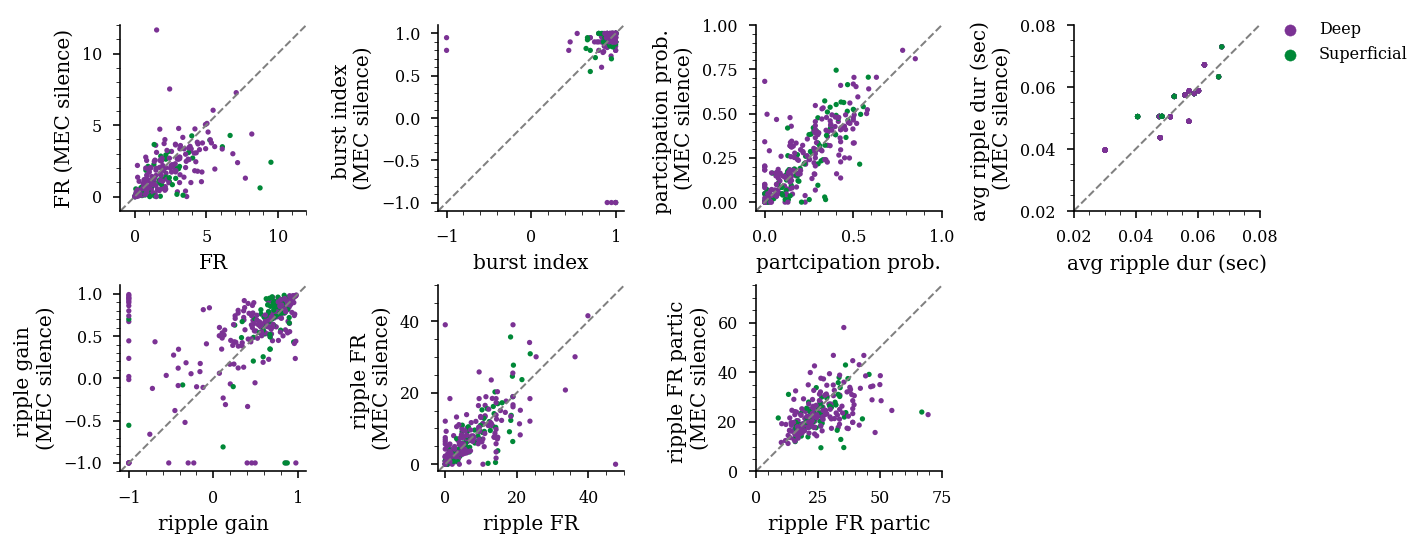

In [409]:
def plot_the_scatter(df,x,y,group_colors,ax,xlabel="",ylabel="",hue="deepSuperficial",scatter_size=7,legend=False):
    sns.scatterplot(
                data=df,
                x=x,
                y=y,
                hue=hue,
                linewidth=0,
                ax=ax,
                legend=legend,
                s=scatter_size,
                hue_order=group_colors.keys(),
                alpha=1
                )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='grey',ls='--',linewidth=1)

group_colors = {"Deep": '#7b3294',
                'Superficial': '#008837'} 

# group_colors_rem_shift = {"rem_shift_deep": '#7b3294',
#                 'non_rem_shift_sup': '#008837',
#                 'unknown':'grey'} 

sns.set_palette(sns.color_palette(group_colors.values()))

fig, axs = plt.subplots(2,4, figsize=functions.set_size('thesis', fraction=2.25, subplots=(2, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0.4, wspace=-.4)
axs = axs.ravel()

plot_the_scatter(df,"avg_fr_not_mec_silence","avg_fr_mec_silence",group_colors,axs[0],xlabel='FR',ylabel='FR (MEC silence)')
plot_the_scatter(df,"burst_idx_not_mec_silence","burst_idx_mec_silence",group_colors,axs[1],xlabel='burst index',ylabel='burst index \n(MEC silence)')
plot_the_scatter(df,"particip_not_mec_silence","particip_mec_silence",group_colors,axs[2],xlabel='partcipation prob.',ylabel='partcipation prob. \n(MEC silence)')
plot_the_scatter(df,"ripple_dur_not_mec_silence","ripple_dur_mec_silence",group_colors,axs[3],xlabel='avg ripple dur (sec)',ylabel='avg ripple dur (sec) \n(MEC silence)',legend=True)
plot_the_scatter(df,"ripple_gain_not_mec_silence","ripple_gain_mec_silence",group_colors,axs[4],xlabel='ripple gain',ylabel='ripple gain \n(MEC silence)')
plot_the_scatter(df,"avg_fr_in_rip_not_mec_silence","avg_fr_in_rip_mec_silence",group_colors,axs[5],xlabel='ripple FR',ylabel='ripple FR \n(MEC silence)')
plot_the_scatter(df,"ripple_fr_particip_not_mec_silence","ripple_fr_particip_mec_silence",group_colors,axs[6],xlabel='ripple FR partic',ylabel='ripple FR partic \n(MEC silence)')


axs[0].set_xlim(-1,12)
axs[0].set_ylim(-1,12)
axs[1].set_xlim(-1.1,1.1)
axs[1].set_ylim(-1.1,1.1)
axs[2].set_xlim(-.05,1)
axs[2].set_ylim(-.05,1)
axs[3].set_xlim(0.02,0.08)
axs[3].set_ylim(0.02,0.08)
axs[4].set_xlim(-1.1,1.1)
axs[4].set_ylim(-1.1,1.1)
axs[5].set_xlim(-2,50)
axs[5].set_ylim(-2,50)
axs[6].set_xlim(0,75)
axs[6].set_ylim(0,75)

for i in range(8):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i].set_aspect('equal')

axs[3].legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 1.1),frameon=False)

axs[7].axes.get_xaxis().set_ticks([])
axs[7].axes.get_yaxis().set_ticks([])
right_side = axs[7].spines["left"]
right_side.set_visible(False)
top_side = axs[7].spines["bottom"]
top_side.set_visible(False)

plt.savefig(os.path.join(fig_save_path,'opto_mec_firing_features_combined.pdf'),dpi=300,bbox_inches='tight')


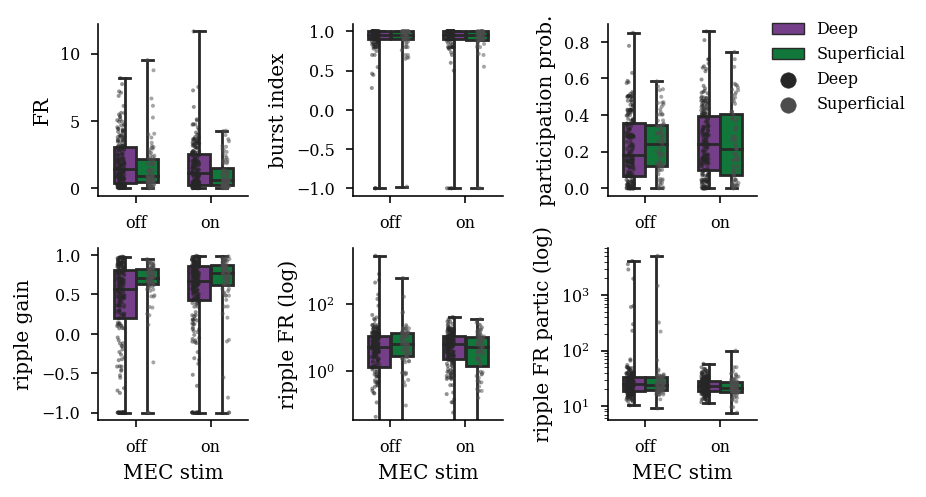

In [464]:
# make data frame where each row is a session
df_stack = pd.DataFrame()
df_stack['basepath'] = list(df.basepath.values) + list(df.basepath.values)
df_stack['avg_fr'] = np.hstack([df["avg_fr_not_mec_silence"].values, df["avg_fr_mec_silence"].values])
df_stack['burst_idx'] = np.hstack([df["burst_idx_not_mec_silence"].values, df["burst_idx_mec_silence"].values])
df_stack['particip'] = np.hstack([df["particip_not_mec_silence"].values, df["particip_mec_silence"].values])
df_stack['ripple_gain'] = np.hstack([df["ripple_gain_not_mec_silence"].values, df["ripple_gain_mec_silence"].values])
df_stack['avg_fr_in_rip'] = np.hstack([df["avg_fr_in_rip_not_mec_silence"].values, df["avg_fr_in_rip_mec_silence"].values])
df_stack['ripple_fr_particip'] = np.hstack([df["ripple_fr_particip_not_mec_silence"].values, df["ripple_fr_particip_mec_silence"].values])
df_stack['deepSuperficial'] = np.hstack([df["deepSuperficial"].values, df["deepSuperficial"].values])
df_stack['mec_stim'] = ["off"]*len(df.basepath) + ["on"]*len(df.basepath)
df_stack['mec_stim_sublayer'] = df_stack['mec_stim'] + df_stack['deepSuperficial']


def plot_the_box(df,x,y,group_colors,ax):
    sns.boxplot(x=x, y=y,hue="deepSuperficial", data=df,
                whis=[0, 100], width=.6,ax=ax,hue_order=group_colors.keys())

    sns.stripplot(x=x, y=y,hue="deepSuperficial", data=df,
                size=2, color=".3", linewidth=0,ax=ax,
                alpha=.5,dodge=True,hue_order=group_colors.keys())


fig, axs = plt.subplots(2,3, figsize=functions.set_size('thesis', fraction=1, subplots=(3, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.7)
axs = axs.ravel()

group_colors = {"Deep": '#7b3294',
                'Superficial': '#008837'} 

sns.set_palette(sns.color_palette(group_colors.values()))

plot_the_box(df_stack,"mec_stim", "avg_fr",group_colors,axs[0])
axs[0].set_ylabel('FR')
axs[0].set_xlabel('MEC stim')

plot_the_box(df_stack,"mec_stim", "burst_idx",group_colors,axs[1])
axs[1].set_ylabel('burst index')
axs[1].set_xlabel('MEC stim')

plot_the_box(df_stack,"mec_stim", "particip",group_colors,axs[2])
axs[2].set_ylabel('participation prob.')
axs[2].set_xlabel('MEC stim')

plot_the_box(df_stack,"mec_stim", "ripple_gain",group_colors,axs[3])
axs[3].set_ylabel('ripple gain')
axs[3].set_xlabel('MEC stim')

plot_the_box(df_stack,"mec_stim", "avg_fr_in_rip",group_colors,axs[4])
axs[4].set_ylabel('ripple FR (log)')
axs[4].set_xlabel('MEC stim')
axs[4].set_yscale("log")

plot_the_box(df_stack,"mec_stim", "ripple_fr_particip",group_colors,axs[5])
axs[5].set_ylabel('ripple FR partic (log)')
axs[5].set_xlabel('MEC stim')
axs[5].set_yscale("log")

axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend([],[], frameon=False)
axs[3].legend([],[], frameon=False)
axs[4].legend([],[], frameon=False)
axs[5].legend([],[], frameon=False)

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")

axs[2].legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 1.1),frameon=False)

sns.despine(trim=False, right=True)

plt.savefig(os.path.join(fig_save_path,'opto_mec_firing_features_combined_box_plot.pdf'),dpi=300,bbox_inches='tight')


# Ratio

<ipython-input-592-1b3cb3d8edac>:7: RuntimeWarning: invalid value encountered in true_divide


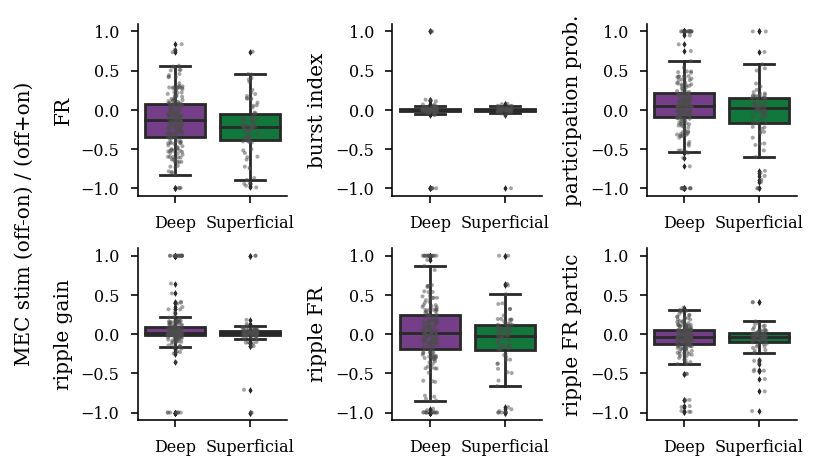

In [592]:
def get_ratio(x1,x2):
    min_val = np.nanmin(np.hstack([x1,x2]))
    if min_val < 0:
        x1 = x1 + np.abs(min_val) + np.finfo(np.float32).eps
        x2 = x2 + np.abs(min_val) + np.finfo(np.float32).eps
    # return (x1 - x2) / (x1 + x2)
    return (x2 - x1) / (x2 + x1)

# df_ratio = pd.DataFrame()
df['avg_fr_ratio'] = get_ratio(df["avg_fr_not_mec_silence"].values,df["avg_fr_mec_silence"].values)
df['burst_idx_ratio'] = get_ratio(df["burst_idx_not_mec_silence"].values,df["burst_idx_mec_silence"].values)
df['particip_ratio'] = get_ratio(df["particip_not_mec_silence"].values, df["particip_mec_silence"].values)
df['ripple_gain_ratio'] = get_ratio(df["ripple_gain_not_mec_silence"].values, df["ripple_gain_mec_silence"].values)
df['avg_fr_in_rip_ratio'] = get_ratio(df["avg_fr_in_rip_not_mec_silence"].values, df["avg_fr_in_rip_mec_silence"].values)
df['ripple_fr_particip_ratio'] = get_ratio(df["ripple_fr_particip_not_mec_silence"].values, df["ripple_fr_particip_mec_silence"].values)

def plot_the_box(df,x,y,group_colors,ax):
    sns.boxplot(x=x, y=y, data=df,fliersize=1,
                 ax=ax,hue_order=group_colors.keys())

    sns.stripplot(x=x, y=y, data=df,
                size=2, color=".3", linewidth=0,ax=ax,
                alpha=.5,dodge=True,hue_order=group_colors.keys())


fig, axs = plt.subplots(2,3, figsize=functions.set_size('thesis', fraction=1, subplots=(3, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.7)
axs = axs.ravel()

group_colors = {"Deep": '#7b3294',
                'Superficial': '#008837'} 

sns.set_palette(sns.color_palette(group_colors.values()))

plot_the_box(df,"deepSuperficial", "avg_fr_ratio",group_colors,axs[0])
axs[0].set_ylabel('FR')

plot_the_box(df,"deepSuperficial", "burst_idx_ratio",group_colors,axs[1])
axs[1].set_ylabel('burst index')

plot_the_box(df,"deepSuperficial", "particip_ratio",group_colors,axs[2])
axs[2].set_ylabel('participation prob.')

plot_the_box(df,"deepSuperficial", "ripple_gain_ratio",group_colors,axs[3])
axs[3].set_ylabel('ripple gain')

plot_the_box(df,"deepSuperficial", "avg_fr_in_rip_ratio",group_colors,axs[4])
axs[4].set_ylabel('ripple FR')

plot_the_box(df,"deepSuperficial", "ripple_fr_particip_ratio",group_colors,axs[5])
axs[5].set_ylabel('ripple FR partic')

axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend([],[], frameon=False)
axs[3].legend([],[], frameon=False)
axs[4].legend([],[], frameon=False)
axs[5].legend([],[], frameon=False)

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")

sns.despine(trim=False, right=True)

for i in range(6):
    axs[i].set_ylim(-1.1,1.1)
    axs[i].set_xlabel('')

fig.text(-.02, 0.5, 'MEC stim (off-on) / (off+on)', va='center', rotation='vertical')

plt.savefig(os.path.join(fig_save_path,'opto_mec_firing_features_combined_box_plot_ratio.pdf'),dpi=300,bbox_inches='tight')


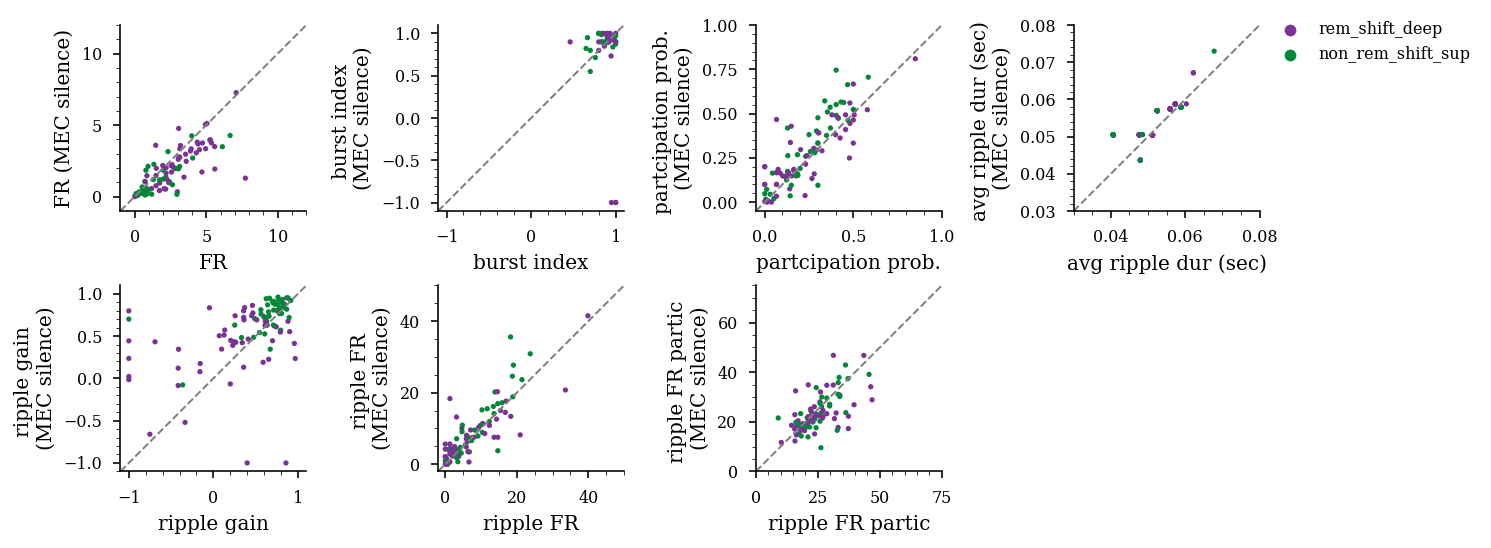

In [362]:
group_colors= {"rem_shift_deep": '#7b3294',
                'non_rem_shift_sup': '#008837'
                } 

sns.set_palette(sns.color_palette(group_colors.values()))

fig, axs = plt.subplots(2,4, figsize=functions.set_size('thesis', fraction=2.25, subplots=(2, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0.4, wspace=-.4)
axs = axs.ravel()

scatter_size = 5

idx = df.rem_shift_layer == "unknown"
plot_the_scatter(df[~idx],"avg_fr_not_mec_silence","avg_fr_mec_silence",group_colors,axs[0],xlabel='FR',ylabel='FR (MEC silence)',hue="rem_shift_layer")
plot_the_scatter(df[~idx],"burst_idx_not_mec_silence","burst_idx_mec_silence",group_colors,axs[1],xlabel='burst index',ylabel='burst index \n(MEC silence)',hue="rem_shift_layer")
plot_the_scatter(df[~idx],"particip_not_mec_silence","particip_mec_silence",group_colors,axs[2],xlabel='partcipation prob.',ylabel='partcipation prob. \n(MEC silence)',hue="rem_shift_layer")
plot_the_scatter(df[~idx],"ripple_dur_not_mec_silence","ripple_dur_mec_silence",group_colors,axs[3],xlabel='avg ripple dur (sec)',ylabel='avg ripple dur (sec) \n(MEC silence)',hue="rem_shift_layer",legend=True)
plot_the_scatter(df[~idx],"ripple_gain_not_mec_silence","ripple_gain_mec_silence",group_colors,axs[4],xlabel='ripple gain',ylabel='ripple gain \n(MEC silence)',hue="rem_shift_layer")
plot_the_scatter(df[~idx],"avg_fr_in_rip_not_mec_silence","avg_fr_in_rip_mec_silence",group_colors,axs[5],xlabel='ripple FR',ylabel='ripple FR \n(MEC silence)',hue="rem_shift_layer")
plot_the_scatter(df[~idx],"ripple_fr_particip_not_mec_silence","ripple_fr_particip_mec_silence",group_colors,axs[6],xlabel='ripple FR partic',ylabel='ripple FR partic \n(MEC silence)',hue="rem_shift_layer")

axs[0].set_xlim(-1,12)
axs[0].set_ylim(-1,12)
axs[1].set_xlim(-1.1,1.1)
axs[1].set_ylim(-1.1,1.1)
axs[2].set_xlim(-.05,1)
axs[2].set_ylim(-.05,1)
axs[3].set_xlim(0.03,0.08)
axs[3].set_ylim(0.03,0.08)
axs[4].set_xlim(-1.1,1.1)
axs[4].set_ylim(-1.1,1.1)
axs[5].set_xlim(-2,50)
axs[5].set_ylim(-2,50)
axs[6].set_xlim(0,75)
axs[6].set_ylim(0,75)

for i in range(8):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i].set_aspect('equal')

axs[3].legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 1.1),frameon=False)

axs[7].axes.get_xaxis().set_ticks([])
axs[7].axes.get_yaxis().set_ticks([])
right_side = axs[7].spines["left"]
right_side.set_visible(False)
top_side = axs[7].spines["bottom"]
top_side.set_visible(False)

plt.savefig(os.path.join(fig_save_path,'opto_mec_firing_features_rem_shift_combined.pdf'),dpi=300,bbox_inches='tight')


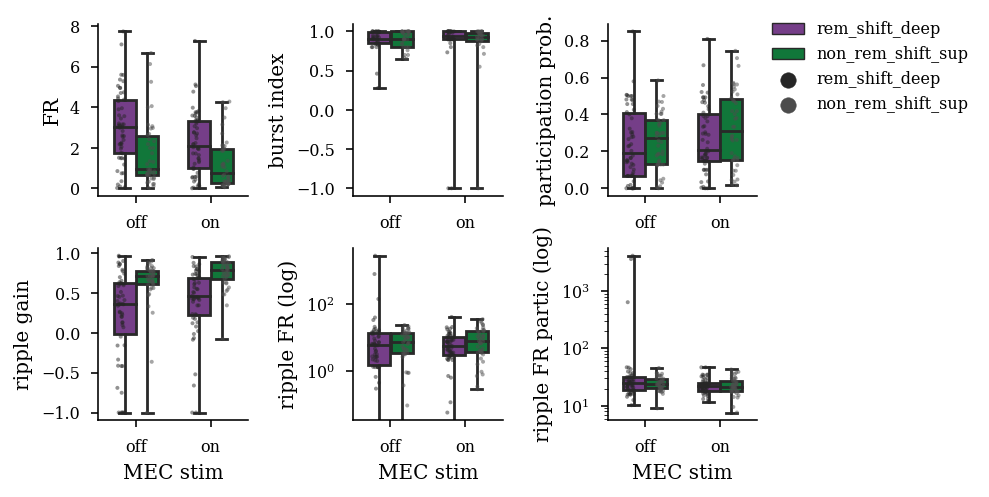

In [470]:
# make data frame where each row is a session
df_stack = pd.DataFrame()
df_stack['basepath'] = list(df.basepath.values) + list(df.basepath.values)
df_stack['avg_fr'] = np.hstack([df["avg_fr_not_mec_silence"].values, df["avg_fr_mec_silence"].values])
df_stack['burst_idx'] = np.hstack([df["burst_idx_not_mec_silence"].values, df["burst_idx_mec_silence"].values])
df_stack['particip'] = np.hstack([df["particip_not_mec_silence"].values, df["particip_mec_silence"].values])
df_stack['ripple_gain'] = np.hstack([df["ripple_gain_not_mec_silence"].values, df["ripple_gain_mec_silence"].values])
df_stack['avg_fr_in_rip'] = np.hstack([df["avg_fr_in_rip_not_mec_silence"].values, df["avg_fr_in_rip_mec_silence"].values])
df_stack['ripple_fr_particip'] = np.hstack([df["ripple_fr_particip_not_mec_silence"].values, df["ripple_fr_particip_mec_silence"].values])
df_stack['deepSuperficial'] = np.hstack([df["deepSuperficial"].values, df["deepSuperficial"].values])
df_stack['rem_shift_layer'] = np.hstack([df["rem_shift_layer"].values, df["rem_shift_layer"].values])
df_stack['mec_stim'] = ["off"]*len(df.basepath) + ["on"]*len(df.basepath)
# df_stack['mec_stim_sublayer'] = df_stack['mec_stim'] + df_stack['deepSuperficial']


def plot_the_box(df,x,y,group_colors,ax,hue="deepSuperficial"):
    sns.boxplot(x=x, y=y,hue=hue, data=df,
                whis=[0, 100], width=.6,ax=ax,hue_order=group_colors.keys())

    sns.stripplot(x=x, y=y,hue=hue, data=df,
                size=2, color=".3", linewidth=0,ax=ax,
                alpha=.5,dodge=True,hue_order=group_colors.keys())


fig, axs = plt.subplots(2,3, figsize=functions.set_size('thesis', fraction=1, subplots=(3, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.7)
axs = axs.ravel()

group_colors= {"rem_shift_deep": '#7b3294',
                'non_rem_shift_sup': '#008837'
                } 

sns.set_palette(sns.color_palette(group_colors.values()))

plot_the_box(df_stack,"mec_stim", "avg_fr",group_colors,axs[0],hue="rem_shift_layer")
axs[0].set_ylabel('FR')
axs[0].set_xlabel('MEC stim')

plot_the_box(df_stack,"mec_stim", "burst_idx",group_colors,axs[1],hue="rem_shift_layer")
axs[1].set_ylabel('burst index')
axs[1].set_xlabel('MEC stim')

plot_the_box(df_stack,"mec_stim", "particip",group_colors,axs[2],hue="rem_shift_layer")
axs[2].set_ylabel('participation prob.')
axs[2].set_xlabel('MEC stim')

plot_the_box(df_stack,"mec_stim", "ripple_gain",group_colors,axs[3],hue="rem_shift_layer")
axs[3].set_ylabel('ripple gain')
axs[3].set_xlabel('MEC stim')

plot_the_box(df_stack,"mec_stim", "avg_fr_in_rip",group_colors,axs[4],hue="rem_shift_layer")
axs[4].set_ylabel('ripple FR (log)')
axs[4].set_xlabel('MEC stim')
axs[4].set_yscale("log")

plot_the_box(df_stack,"mec_stim", "ripple_fr_particip",group_colors,axs[5],hue="rem_shift_layer")
axs[5].set_ylabel('ripple FR partic (log)')
axs[5].set_xlabel('MEC stim')
axs[5].set_yscale("log")

axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend([],[], frameon=False)
axs[3].legend([],[], frameon=False)
axs[4].legend([],[], frameon=False)
axs[5].legend([],[], frameon=False)

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")

axs[2].legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 1.1),frameon=False)

sns.despine(trim=False, right=True)

plt.savefig(os.path.join(fig_save_path,'opto_mec_firing_features_rem_shift_combined_box_plot.pdf'),dpi=300,bbox_inches='tight')


<ipython-input-564-4934d5476a03>:7: RuntimeWarning: invalid value encountered in true_divide


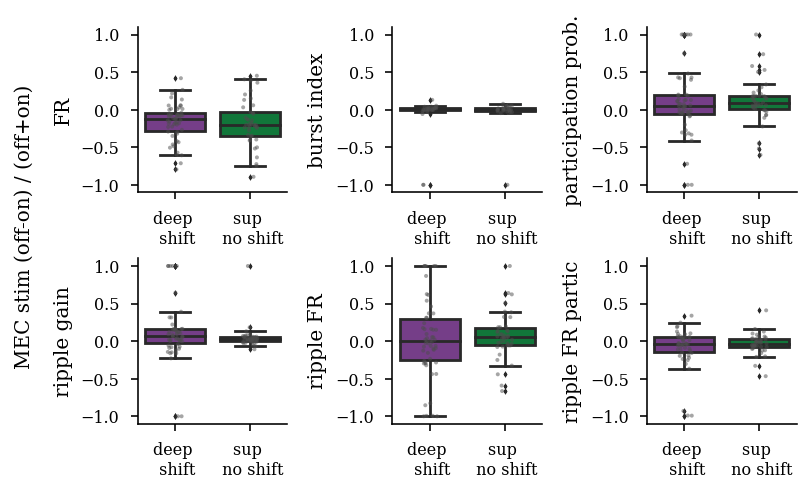

In [586]:
# df_ratio = pd.DataFrame()
df['avg_fr_ratio'] = get_ratio(df["avg_fr_not_mec_silence"].values,df["avg_fr_mec_silence"].values)
df['burst_idx_ratio'] = get_ratio(df["burst_idx_not_mec_silence"].values,df["burst_idx_mec_silence"].values)
df['particip_ratio'] = get_ratio(df["particip_not_mec_silence"].values, df["particip_mec_silence"].values)
df['ripple_gain_ratio'] = get_ratio(df["ripple_gain_not_mec_silence"].values, df["ripple_gain_mec_silence"].values)
df['avg_fr_in_rip_ratio'] = get_ratio(df["avg_fr_in_rip_not_mec_silence"].values, df["avg_fr_in_rip_mec_silence"].values)
df['ripple_fr_particip_ratio'] = get_ratio(df["ripple_fr_particip_not_mec_silence"].values, df["ripple_fr_particip_mec_silence"].values)

def plot_the_box(df,x,y,group_colors,ax):
    sns.boxplot(x=x, y=y, data=df,fliersize=1,
                 ax=ax,hue_order=group_colors.keys())

    sns.stripplot(x=x, y=y, data=df,
                size=2, color=".3", linewidth=0,ax=ax,
                alpha=.5,dodge=True,hue_order=group_colors.keys())


fig, axs = plt.subplots(2,3, figsize=functions.set_size('thesis', fraction=1, subplots=(3, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.4, wspace=.7)
axs = axs.ravel()

group_colors= {"rem_shift_deep": '#7b3294',
                'non_rem_shift_sup': '#008837'
                } 

sns.set_palette(sns.color_palette(group_colors.values()))

idx = (df.rem_shift_layer == "rem_shift_deep") | (df.rem_shift_layer == "non_rem_shift_sup")

plot_the_box(df[idx],"rem_shift_layer", "avg_fr_ratio",group_colors,axs[0])
axs[0].set_ylabel('FR')

plot_the_box(df[idx],"rem_shift_layer", "burst_idx_ratio",group_colors,axs[1])
axs[1].set_ylabel('burst index')

plot_the_box(df[idx],"rem_shift_layer", "particip_ratio",group_colors,axs[2])
axs[2].set_ylabel('participation prob.')

plot_the_box(df[idx],"rem_shift_layer", "ripple_gain_ratio",group_colors,axs[3])
axs[3].set_ylabel('ripple gain')

plot_the_box(df[idx],"rem_shift_layer", "avg_fr_in_rip_ratio",group_colors,axs[4])
axs[4].set_ylabel('ripple FR')

plot_the_box(df[idx],"rem_shift_layer", "ripple_fr_particip_ratio",group_colors,axs[5])
axs[5].set_ylabel('ripple FR partic')

axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend([],[], frameon=False)
axs[3].legend([],[], frameon=False)
axs[4].legend([],[], frameon=False)
axs[5].legend([],[], frameon=False)

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")

sns.despine(trim=False, right=True)

for i in range(6):
    axs[i].set_ylim(-1.1,1.1)
    axs[i].set_xlabel('')
    axs[i].set_xticklabels(["deep \n shift","sup \n no shift"], fontsize=8 )

fig.text(-.02, 0.5, 'MEC stim (off-on) / (off+on)', va='center', rotation='vertical')

plt.savefig(os.path.join(fig_save_path,'opto_mec_firing_features_rem_shift_combined_box_plot_ratio.pdf'),dpi=300,bbox_inches='tight')


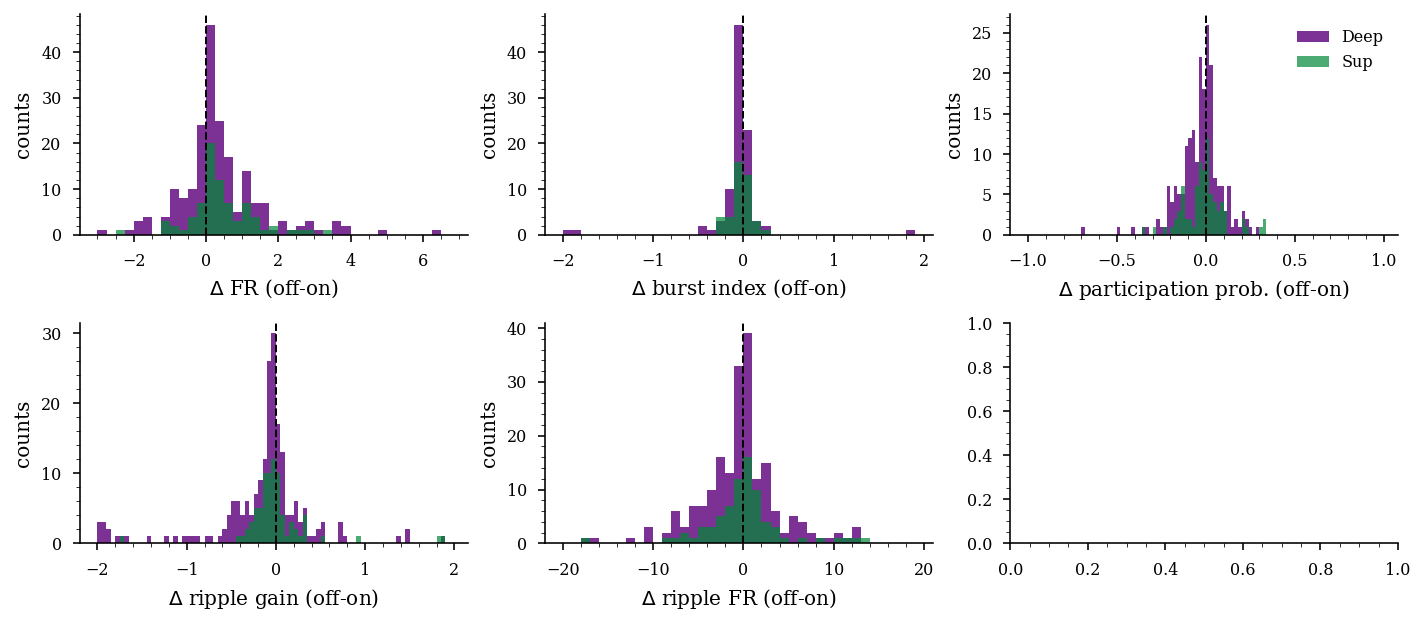

In [98]:
fig, axs = plt.subplots(2,3, figsize=functions.set_size('thesis', fraction=2, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.4, wspace=.2)
axs = axs.ravel()

group_colors = {"Deep": '#7b3294',
                'Superficial': '#008837'} 
ax = 0
axs[ax].hist(df[df.deepSuperficial=="Deep"].avg_fr_not_mec_silence-df[df.deepSuperficial=="Deep"].avg_fr_mec_silence,
            color=group_colors['Deep'],
            label="Deep",
            bins=np.arange(-3,7,.25))
axs[ax].hist(df[df.deepSuperficial=="Superficial"].avg_fr_not_mec_silence-df[df.deepSuperficial=="Superficial"].avg_fr_mec_silence,
            color=group_colors['Superficial'],
            label="Sup",
            bins=np.arange(-3,7,.25),alpha=.7)
axs[ax].axvline(x=0,color='k',ls='--',linewidth=1)
axs[ax].set_xlabel('$\Delta$ FR (off-on)')
axs[ax].set_ylabel('counts')

ax = 1
axs[ax].hist(df[df.deepSuperficial=="Deep"].burst_idx_not_mec_silence-df[df.deepSuperficial=="Deep"].burst_idx_mec_silence,
            color=group_colors['Deep'],
            label="Deep",
            bins=np.arange(-2,2,.1))
axs[ax].hist(df[df.deepSuperficial=="Superficial"].burst_idx_not_mec_silence-df[df.deepSuperficial=="Superficial"].burst_idx_mec_silence,
            color=group_colors['Superficial'],
            label="Sup",
            bins=np.arange(-2,2,.1),alpha=.7)
axs[ax].axvline(x=0,color='k',ls='--',linewidth=1)
axs[ax].set_xlabel('$\Delta$ burst index (off-on)')
axs[ax].set_ylabel('counts')

ax = 2
axs[ax].hist(df[df.deepSuperficial=="Deep"].particip_not_mec_silence-df[df.deepSuperficial=="Deep"].particip_mec_silence,
            color=group_colors['Deep'],
            label="Deep",bins=np.arange(-1,1,.02))
axs[ax].hist(df[df.deepSuperficial=="Superficial"].particip_not_mec_silence-df[df.deepSuperficial=="Superficial"].particip_mec_silence,
            color=group_colors['Superficial'],
            label="Sup",bins=np.arange(-1,1,.02),alpha=.7)
axs[ax].axvline(x=0,color='k',ls='--',linewidth=1)
axs[ax].set_xlabel('$\Delta$ participation prob. (off-on)')
axs[ax].set_ylabel('counts')

ax = 3
axs[ax].hist(df[df.deepSuperficial=="Deep"].ripple_gain_not_mec_silence-df[df.deepSuperficial=="Deep"].ripple_gain_mec_silence,
            color=group_colors['Deep'],
            label="Deep",bins=np.arange(-2,2,0.05))
axs[ax].hist(df[df.deepSuperficial=="Superficial"].ripple_gain_not_mec_silence-df[df.deepSuperficial=="Superficial"].ripple_gain_mec_silence,
            color=group_colors['Superficial'],
            label="Sup",bins=np.arange(-2,2,0.05),alpha=.7)
axs[ax].axvline(x=0,color='k',ls='--',linewidth=1)
axs[ax].set_xlabel('$\Delta$ ripple gain (off-on)')
axs[ax].set_ylabel('counts')

ax = 4
axs[ax].hist(df[df.deepSuperficial=="Deep"].avg_fr_in_rip_not_mec_silence-df[df.deepSuperficial=="Deep"].avg_fr_in_rip_mec_silence,
            color=group_colors['Deep'],
            label="Deep",bins=np.arange(-20,20,1))
axs[ax].hist(df[df.deepSuperficial=="Superficial"].avg_fr_in_rip_not_mec_silence-df[df.deepSuperficial=="Superficial"].avg_fr_in_rip_mec_silence,
            color=group_colors['Superficial'],
            label="Sup",bins=np.arange(-20,20,1),alpha=.7)
axs[ax].axvline(x=0,color='k',ls='--',linewidth=1)
axs[ax].set_xlabel('$\Delta$ ripple FR (off-on)')
axs[ax].set_ylabel('counts')

for i in range(6):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs[2].legend(loc='best',frameon=False)

plt.savefig(os.path.join(fig_save_path,'opto_mec_firing_features_hist_combined.pdf'),dpi=300,bbox_inches='tight')



# Look at how MEC silencing effects intrinsic properties over pre/task/post

In [195]:
# display(cell_metrics_data['epochs'])

# cell_metrics_data['epochs'].name.str.contains("linear", case=False)

,name,startTime,stopTime
0,OR18day1_preSleep_190915_094606,0.000000,11105.215967
1,OML18day1_linear_190915_130243,11105.216000,11454.092767
2,OML18day1_linear_190915_130837,11454.092800,14982.250633
3,OML18day1_postSleep_190915_142442,14982.250667,26547.647967


0    False
1     True
2     True
3    False
Name: name, dtype: bool

In [201]:
# temp_cell_metrics,_ = loading.load_cell_metrics(basepath)
# temp_swr_unit_metric = loading.load_SWRunitMetrics(basepath)
# temp_swr_unit_metric.epoch.unique().shape[0]

3

In [198]:
# n_epochs = temp_swr_unit_metric.epoch.unique().shape[0]

# for _ in range(temp_swr_unit_metric.epoch.nunique()-1):
#     temp_cell_metrics = temp_cell_metrics.append(temp_cell_metrics,ignore_index=True)

In [602]:
swr_unit_metric = pd.DataFrame()
for basepath in basepaths:

    temp_swr_unit_metric = loading.load_SWRunitMetrics(basepath)
    temp_cell_metrics,_ = loading.load_cell_metrics(basepath)

    for _ in range(temp_swr_unit_metric.epoch.nunique()-1):
        temp_cell_metrics = temp_cell_metrics.append(temp_cell_metrics,ignore_index=True)
    
    temp_swr_unit_metric['deepSuperficial'] = temp_cell_metrics.deepSuperficial
    temp_swr_unit_metric['brainRegion'] = temp_cell_metrics.brainRegion
    temp_swr_unit_metric['putativeCellType'] = temp_cell_metrics.putativeCellType
    temp_swr_unit_metric['basepath'] = temp_cell_metrics.basepath
    temp_swr_unit_metric['UID'] = temp_cell_metrics.UID

    swr_unit_metric = swr_unit_metric.append(temp_swr_unit_metric,ignore_index=True)
    
swr_unit_metric

,particip,FRall,FRparticip,nSpkAll,nSpkParticip,epoch,deepSuperficial,brainRegion,putativeCellType,basepath,UID
0,0.000000,0.000000,NaN,0.000000,NaN,pre,Deep,CA1,Narrow Interneuron,A:\OptoMECLEC\OML18\day1,1
1,0.614286,8.566100,13.978432,1.128571,1.837209,pre,Deep,CA1,Narrow Interneuron,A:\OptoMECLEC\OML18\day1,2
2,0.942857,30.686155,32.561103,4.042857,4.287879,pre,Deep,CA1,Wide Interneuron,A:\OptoMECLEC\OML18\day1,3
3,0.242857,3.578244,14.562020,0.471429,1.941176,pre,Superficial,CA3DG,Pyramidal Cell,A:\OptoMECLEC\OML18\day1,4
4,0.828571,18.650243,22.588798,2.457143,2.965517,pre,Deep,CA1,Pyramidal Cell,A:\OptoMECLEC\OML18\day1,5
...,...,...,...,...,...,...,...,...,...,...,...
1061,0.409800,5.231585,12.514301,0.718263,1.752717,post,Deep,CA1,Pyramidal Cell,A:\OptoMECLEC\OML7\day9,30
1062,0.747773,11.428377,15.066504,1.569042,2.098287,post,Deep,CA1,Pyramidal Cell,A:\OptoMECLEC\OML7\day9,31
1063,0.844098,20.524846,24.017990,2.817929,3.338391,post,Deep,CA1,Pyramidal Cell,A:\OptoMECLEC\OML7\day9,32
1064,0.538976,9.631794,17.934025,1.322383,2.453512,post,Deep,CA1,Wide Interneuron,A:\OptoMECLEC\OML7\day9,33


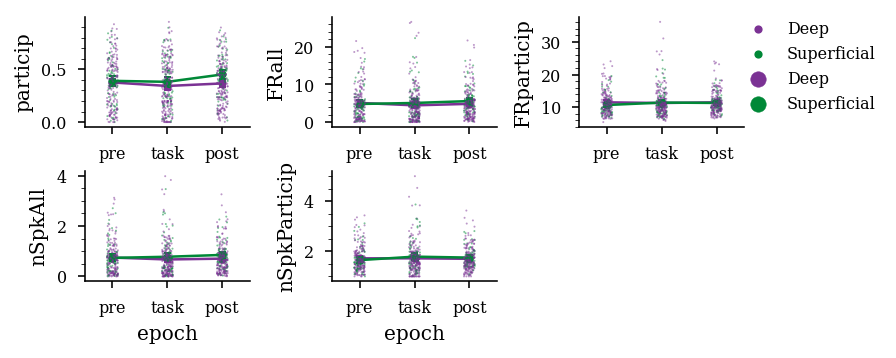

In [595]:
def plot_paired_plot(df,y,group_colors,ax,x="epoch",hue="deepSuperficial"):
    sns.pointplot(
            data=df,
            x=x, 
            y=y, 
            hue=hue,
            ci=95,
            capsize=.1, 
            hue_order=group_colors.keys(), 
            kind="point",
            ax=ax,
            scale=.5,
            errwidth=1
            ) 
    sns.stripplot(x=x, y=y,hue=hue,hue_order=group_colors.keys(),
        data=df,size=1,linewidth=0,ax=ax,alpha=.5)

fig, axs = plt.subplots(2,3, figsize=functions.set_size('thesis', fraction=1, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.4, wspace=.5)
axs = axs.ravel()

group_colors = {"Deep": '#7b3294',
            'Superficial': '#008837'} 
sns.set_palette(sns.color_palette(group_colors.values()))

idx = (swr_unit_metric.putativeCellType=="Pyramidal Cell") & (swr_unit_metric.brainRegion=="CA1")

plot_paired_plot(swr_unit_metric[idx],"particip",group_colors,axs[0])
plot_paired_plot(swr_unit_metric[idx],"FRall",group_colors,axs[1])
plot_paired_plot(swr_unit_metric[idx],"FRparticip",group_colors,axs[2])
plot_paired_plot(swr_unit_metric[idx],"nSpkAll",group_colors,axs[3])
plot_paired_plot(swr_unit_metric[idx],"nSpkParticip",group_colors,axs[4])

axs[0].legend("",frameon=False)
axs[1].legend("",frameon=False)
axs[3].legend("",frameon=False)
axs[4].legend("",frameon=False)

axs[2].legend(loc='best', bbox_to_anchor=(.9, 0., 0.5, 1.1),frameon=False)
    
for i in range(6):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs[5].axes.get_xaxis().set_ticks([])
axs[5].axes.get_yaxis().set_ticks([])

right_side = axs[5].spines["left"]
right_side.set_visible(False)
top_side = axs[5].spines["bottom"]
top_side.set_visible(False)

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")

plt.savefig(os.path.join(fig_save_path,'opto_mec_pre_task_post_combined.pdf'),dpi=300,bbox_inches='tight')

# Get ratios of features between task epochs

In [661]:
def get_ratio(x1,x2):
    min_val = np.nanmin(np.hstack([x1,x2]))
    if min_val < 0:
        x1 = x1 + np.abs(min_val) + np.finfo(np.float32).eps
        x2 = x2 + np.abs(min_val) + np.finfo(np.float32).eps
    return (x2 - x1) / (x2 + x1)

def get_ratio_var_helper(df,var,cond1,cond2):
     return get_ratio(df[df.epoch == cond1][var].values,df[df.epoch == cond2][var].values)

particip_ratio_pre_task = []
particip_ratio_pre_post = []
FRall_ratio_pre_task = []
FRall_ratio_pre_post = []
FRparticip_ratio_pre_task = []
FRparticip_ratio_pre_post = []
nSpkAll_ratio_pre_task = []
nSpkAll_ratio_pre_post = []
nSpkParticip_ratio_pre_task = []
nSpkParticip_ratio_pre_post = []
basepaths = []
deepSuperficial = []
putativeCellType = []
brainRegion = []
for basepath in swr_unit_metric.basepath.unique():
    temp_df = swr_unit_metric[swr_unit_metric.basepath == basepath]

    if (temp_df.epoch == "pre").any() & (temp_df.epoch == "task").any() & (temp_df.epoch == "post").any():

        particip_ratio_pre_task.append(get_ratio_var_helper(temp_df,"particip","pre","task"))
        particip_ratio_pre_post.append(get_ratio_var_helper(temp_df,"particip","pre","post"))

        FRall_ratio_pre_task.append(get_ratio_var_helper(temp_df,"FRall","pre","task"))
        FRall_ratio_pre_post.append(get_ratio_var_helper(temp_df,"FRall","pre","post"))

        FRparticip_ratio_pre_task.append(get_ratio_var_helper(temp_df,"FRparticip","pre","task"))
        FRparticip_ratio_pre_post.append(get_ratio_var_helper(temp_df,"FRparticip","pre","post"))

        nSpkAll_ratio_pre_task.append(get_ratio_var_helper(temp_df,"nSpkAll","pre","task"))
        nSpkAll_ratio_pre_post.append(get_ratio_var_helper(temp_df,"nSpkAll","pre","post"))

        nSpkParticip_ratio_pre_task.append(get_ratio_var_helper(temp_df,"nSpkParticip","pre","task"))
        nSpkParticip_ratio_pre_post.append(get_ratio_var_helper(temp_df,"nSpkParticip","pre","post"))

        basepaths.append(temp_df[temp_df.epoch == "pre"].basepath)
        deepSuperficial.append(temp_df[temp_df.epoch == "pre"].deepSuperficial)
        putativeCellType.append(temp_df[temp_df.epoch == "pre"].putativeCellType)
        brainRegion.append(temp_df[temp_df.epoch == "pre"].brainRegion)

swr_unit_metric_ratio = pd.DataFrame()
swr_unit_metric_ratio["particip_ratio"] = np.hstack([np.hstack(particip_ratio_pre_task),np.hstack(particip_ratio_pre_post)])
swr_unit_metric_ratio["FRall_ratio"] = np.hstack([np.hstack(FRall_ratio_pre_task),np.hstack(FRall_ratio_pre_post)])
swr_unit_metric_ratio["FRparticip_ratio"] = np.hstack([np.hstack(FRparticip_ratio_pre_task),np.hstack(FRparticip_ratio_pre_post)])
swr_unit_metric_ratio["nSpkAll_ratio"] = np.hstack([np.hstack(nSpkAll_ratio_pre_task),np.hstack(nSpkAll_ratio_pre_post)])
swr_unit_metric_ratio["nSpkParticip_ratio"] = np.hstack([np.hstack(nSpkParticip_ratio_pre_task),np.hstack(nSpkParticip_ratio_pre_post)])
swr_unit_metric_ratio["basepath"] = np.hstack([np.hstack(basepaths),np.hstack(basepaths)])
swr_unit_metric_ratio["deepSuperficial"] = np.hstack([np.hstack(deepSuperficial),np.hstack(deepSuperficial)])
swr_unit_metric_ratio["putativeCellType"] = np.hstack([np.hstack(putativeCellType),np.hstack(putativeCellType)])
swr_unit_metric_ratio["brainRegion"] = np.hstack([np.hstack(brainRegion),np.hstack(brainRegion)])
swr_unit_metric_ratio['ratio'] = ["pre_task"]*len(np.hstack(basepaths)) + ["pre_post"]*len(np.hstack(basepaths))

<ipython-input-661-811a048553a7>:6: RuntimeWarning: invalid value encountered in true_divide


In [662]:
swr_unit_metric_ratio = swr_unit_metric_ratio[(swr_unit_metric_ratio.putativeCellType == "Pyramidal Cell") & (swr_unit_metric_ratio.brainRegion == "CA1")]

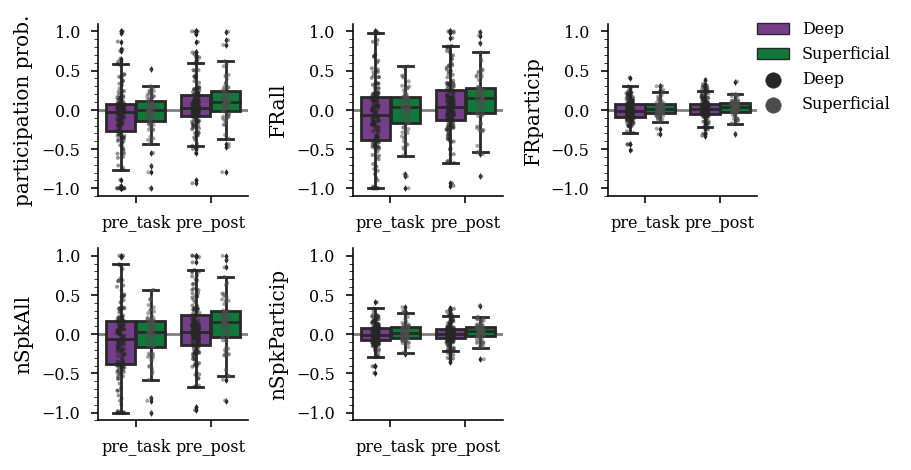

In [664]:
def plot_the_box(df,x,y,group_colors,ax):
    sns.boxplot(x=x, y=y, data=df,fliersize=1,hue="deepSuperficial",
                 ax=ax,hue_order=group_colors.keys())

    sns.stripplot(x=x, y=y, data=df,
                size=2, color=".3", linewidth=0,ax=ax,hue="deepSuperficial",
                alpha=.5,dodge=True,hue_order=group_colors.keys())
    ax.axhline(0,color='grey',zorder=-1000)

fig, axs = plt.subplots(2,3, figsize=functions.set_size('thesis', fraction=1, subplots=(3, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.7)
axs = axs.ravel()

group_colors = {"Deep": '#7b3294',
                'Superficial': '#008837'} 

sns.set_palette(sns.color_palette(group_colors.values()))

plot_the_box(swr_unit_metric_ratio,"ratio", "particip_ratio",group_colors,axs[0])
axs[0].set_ylabel('participation prob.')

plot_the_box(swr_unit_metric_ratio,"ratio", "FRall_ratio",group_colors,axs[1])
axs[1].set_ylabel('FRall')

plot_the_box(swr_unit_metric_ratio,"ratio", "FRparticip_ratio",group_colors,axs[2])
axs[2].set_ylabel('FRparticip')

plot_the_box(swr_unit_metric_ratio,"ratio", "nSpkAll_ratio",group_colors,axs[3])
axs[3].set_ylabel('nSpkAll')

plot_the_box(swr_unit_metric_ratio,"ratio", "nSpkParticip_ratio",group_colors,axs[4])
axs[4].set_ylabel('nSpkParticip')


axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend([],[], frameon=False)
axs[3].legend([],[], frameon=False)
axs[4].legend([],[], frameon=False)
axs[5].legend([],[], frameon=False)

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")

sns.despine(trim=False, right=True)

for i in range(6):
    axs[i].set_ylim(-1.1,1.1)
    axs[i].set_xlabel('')

axs[5].axes.get_xaxis().set_ticks([])
axs[5].axes.get_yaxis().set_ticks([])
right_side = axs[5].spines["left"]
right_side.set_visible(False)
top_side = axs[5].spines["bottom"]
top_side.set_visible(False)

for i in range(6):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())
    
axs[2].legend(loc='best', bbox_to_anchor=(.9, 0., 0.5, 1.1),frameon=False)

# fig.text(-.02, 0.5, 'MEC stim (off-on) / (off+on)', va='center', rotation='vertical')

plt.savefig(os.path.join(fig_save_path,'opto_mec_pre_task_post_combined_ratio.pdf'),dpi=300,bbox_inches='tight')


# compare single session ripple features

In [276]:
# make data frame where each row is a session
df_session = pd.DataFrame()
df_session['basepath'] = basepaths+basepaths
df_session['n_ripples'] = n_ripples_not_mec_silence+n_ripples_mec_silence
df_session['ripple_rate'] = ripple_rate_not_mec_silence+ripple_rate_mec_silence
df_session['mec_stim'] = ["off"]*len(ripple_rate_not_mec_silence) + ["on"]*len(ripple_rate_not_mec_silence)

# make data frame where each row is a ripple
df_session_dur = pd.DataFrame()
mec_stim_off = []
lengths = [len(a) for a in ripple_dur_not_mec_silence]
for item in lengths:
    mec_stim_off.append(['off']*item)

mec_stim_on = []
lengths = [len(a) for a in ripple_dur_mec_silence]
for item in lengths:
    mec_stim_on.append(['on']*item)

df_session_dur['prop_act_per_rip'] = np.hstack([np.hstack(prop_act_per_rip_mec_not_silence),np.hstack(prop_act_per_rip_mec_silence)])
df_session_dur['ripple_dur'] = np.hstack([np.hstack(ripple_dur_not_mec_silence),np.hstack(ripple_dur_mec_silence)])
df_session_dur['mec_stim'] = ["off"]*len(np.hstack(ripple_dur_not_mec_silence)) + ["on"]*len(np.hstack(ripple_dur_mec_silence))

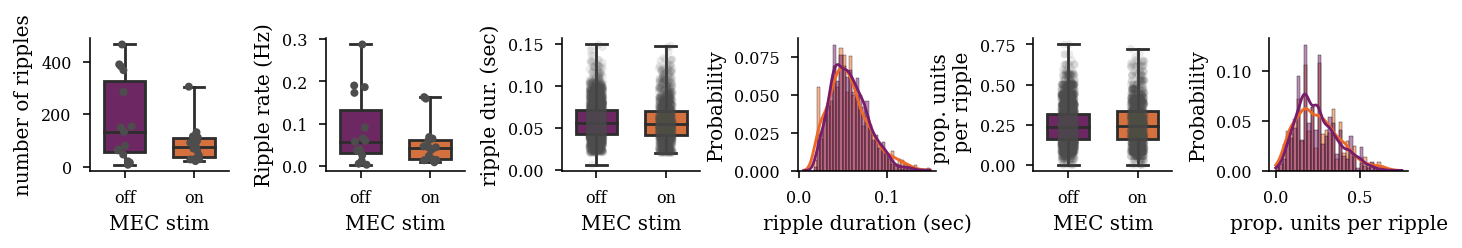

In [290]:
fig, axs = plt.subplots(1,6, figsize=functions.set_size('thesis', fraction=2, subplots=(1, 6)), edgecolor='k')
fig.subplots_adjust(hspace = 0.4, wspace=.7)
axs = axs.ravel()

sns.boxplot(x="mec_stim", y="n_ripples", data=df_session,
            whis=[0, 100], width=.6,ax=axs[0],palette = "inferno")
sns.stripplot(x="mec_stim", y="n_ripples", data=df_session,
              size=4, color=".3", linewidth=0,ax=axs[0])
axs[0].set_ylabel('number of ripples')
axs[0].set_xlabel('MEC stim')

sns.boxplot(x="mec_stim", y="ripple_rate", data=df_session,
            whis=[0, 100], width=.6,ax=axs[1],palette = "inferno")
sns.stripplot(x="mec_stim", y="ripple_rate", data=df_session,
              size=4, color=".3", linewidth=0,ax=axs[1])
axs[1].set_ylabel('Ripple rate (Hz)')
axs[1].set_xlabel('MEC stim')
sns.despine(trim=False, right=True)

sns.boxplot(x="mec_stim", y="ripple_dur", data=df_session_dur,
            whis=[0, 100], width=.6,ax=axs[2],palette = "inferno")
sns.stripplot(x="mec_stim", y="ripple_dur", data=df_session_dur,
              size=4, color=".3", linewidth=0,ax=axs[2],alpha=.1)
axs[2].set_ylabel('ripple dur. (sec)')
axs[2].set_xlabel('MEC stim')

p = sns.histplot(
    data=df_session_dur,
    x="ripple_dur", hue="mec_stim",
    palette="inferno",
    common_norm=False,
    stat="probability",
    log_scale=False,
    kde=True,
    ax=axs[3],
    legend=False
)
axs[3].set_xlabel('ripple duration (sec)')
sns.despine(trim=False, right=True)
# p.legend(["on","off"],bbox_to_anchor=(.75, 0., 0.5, 1.1),frameon=False)


sns.boxplot(x="mec_stim", y="prop_act_per_rip", data=df_session_dur,
            whis=[0, 100], width=.6,ax=axs[4],palette = "inferno")
sns.stripplot(x="mec_stim", y="prop_act_per_rip", data=df_session_dur,
              size=4, color=".3", linewidth=0,ax=axs[4],alpha=.1)
axs[4].set_ylabel('prop. units \n per ripple')
axs[4].set_xlabel('MEC stim')


p = sns.histplot(
    data=df_session_dur,
    x="prop_act_per_rip", hue="mec_stim",
    palette="inferno",
    common_norm=False,
    stat="probability",
    log_scale=False,
    kde=True,
    ax=axs[5],
    legend=False
)
axs[5].set_xlabel('prop. units per ripple')

plt.savefig(os.path.join(fig_save_path,'ripple_session_features.pdf'),dpi=300,bbox_inches='tight')

# Run same analysis just on cheeseboard task

In [253]:
def load_cheesbTrialsDayOffset(basepath):
    filename = glob.glob(basepath+os.sep+'cheesbTrialsDayOffset.mat')[0]
    # check if saved file exists
    if not os.path.exists(filename):
        warnings.warn("file does not exist")
        return np.nan
    
    data = sio.loadmat(filename)

    missing_array = np.array([[np.nan,np.nan],[np.nan,np.nan]]).T

    try:
        trial_start = data['cheesbTrialsDay']['trials'][0][0]['start'][0][0].T[0]
        trial_end = data['cheesbTrialsDay']['trials'][0][0]['end'][0][0].T[0]
        trial = np.array([trial_start,trial_end]).T
    except:
        trial = missing_array

    try:    
        trial_start = data['cheesbTrialsDay']['preProbe'][0][0]['start'][0][0].T[0]
        trial_end = data['cheesbTrialsDay']['preProbe'][0][0]['end'][0][0].T[0]
        preProbe = np.array([trial_start,trial_end]).T    
    except:
        preProbe = missing_array

    try:    
        trial_start = data['cheesbTrialsDay']['postProbe'][0][0]['start'][0][0].T[0]
        trial_end = data['cheesbTrialsDay']['postProbe'][0][0]['end'][0][0].T[0]
        postProbe = np.array([trial_start,trial_end]).T   
    except:
        postProbe = missing_array
        
    return trial,preProbe,postProbe

def load_format_data(basepath):
    # channel and fs info
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)

    # spike data and other
    cell_metrics,cell_metrics_data = loading.load_cell_metrics(basepath)

    # make spike train object
    st = nel.SpikeTrainArray(
                    timestamps=np.array(cell_metrics_data['spikes'],dtype="object"),
                    fs=fs_dat)

    # load stimulation
    # stim_on = load_stimint(basepath)
    trial,preProbe,postProbe = load_cheesbTrialsDayOffset(basepath)   
    mec_silence_epochs = nel.EpochArray([trial])

    # ripple epochs
    ripples = loading.load_ripples_events(basepath)
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])

    # get session epoch
    # this data has pre/post probe
    all_trial = np.vstack([[preProbe[0,0],preProbe[-1,1]],
                            [trial[0,0],trial[-1,1]],
                            [postProbe[0,0],postProbe[-1,1]]]
                            )
    # remove nans
    all_trial = all_trial[~np.isnan(all_trial).any(axis=1),:]
                      
    behav_epoch = nel.EpochArray([all_trial])

    return st,behav_epoch,mec_silence_epochs,ripple_epochs

st,behav_epoch,mec_silence_epochs,ripple_epochs = load_format_data(basepaths[0])


print('behav_epoch ',behav_epoch)
print('spike train ',st)
print('mec_silence_epochs ',mec_silence_epochs)
print('ripple_epochs ',ripple_epochs)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


behav_epoch  <EpochArray at 0x28ca2eb5a00: 3 epochs> of length 1:11:15:106 hours
spike train  <SpikeTrainArray at 0x28ca153da60: 15 units> at 30000 Hz
mec_silence_epochs  <EpochArray at 0x28ca2eb5ac0: 31 epochs> of length 32:27:823 minutes
ripple_epochs  <EpochArray at 0x28ca2eb59a0: 1,874 epochs> of length 1:59:848 minutes


In [171]:
basepaths = ['A:/OptoMECLEC/OML5/day4',
            'A:/OptoMECLEC/OML5/day6',  
            'A:/OptoMECLEC/OML5/day8', 
            'A:/OptoMECLEC/OML5/day21',   
            'A:/OptoMECLEC/OML3/day11',  
            'A:/OptoMECLEC/OML3/day13' , 
            'A:/OptoMECLEC/OML3/day14',   
            'A:/OptoMECLEC/OML7/day6',  
            'A:/OptoMECLEC/OML7/day9']
            
df = pd.DataFrame()

for basepath in basepaths:

    temp_df = pd.DataFrame()

    st,behav_epoch,mec_silence_epochs,ripple_epochs = load_format_data(basepath)

    avg_fr_not_mec_silence = (st[behav_epoch][~mec_silence_epochs].n_spikes /
                                st[behav_epoch][~mec_silence_epochs].support.duration)
    avg_fr_mec_silence = (st[behav_epoch][mec_silence_epochs].n_spikes /
                            st[behav_epoch][mec_silence_epochs].support.duration)

    # mean ripple durations
    ripple_dur_not_mec_silence = ripple_epochs[behav_epoch][~mec_silence_epochs].lengths.mean()
    ripple_dur_mec_silence = ripple_epochs[behav_epoch][mec_silence_epochs].lengths.mean()

    # get participation prob.
    particip_not_mec_silence,particip_mec_silence = get_participation(st,
                                                                    ripple_epochs,
                                                                    behav_epoch,
                                                                    mec_silence_epochs)

    # ripple gain
    ripple_gain_not_mec_silence,ripple_gain_mec_silence = get_ripple_gain(st,
                                                                        ripple_epochs,
                                                                        behav_epoch,
                                                                        mec_silence_epochs)
    
    # get avg ripple fr
    avg_fr_in_rip_not_mec_silence = (st[behav_epoch][ripple_epochs][~mec_silence_epochs].n_spikes /
                                        st[behav_epoch][ripple_epochs][~mec_silence_epochs].support.duration)
    avg_fr_in_rip_mec_silence = (st[behav_epoch][ripple_epochs][mec_silence_epochs].n_spikes /
                                    st[behav_epoch][ripple_epochs][mec_silence_epochs].support.duration)
    
    # get burst idx
    autocorrs = functions.compute_AutoCorrs(st[behav_epoch][ripple_epochs][~mec_silence_epochs].data)
    burst_idx_not_mec_silence = functions.BurstIndex_Royer_2012(autocorrs)

    autocorrs = functions.compute_AutoCorrs(st[behav_epoch][ripple_epochs][mec_silence_epochs].data)
    burst_idx_mec_silence = functions.BurstIndex_Royer_2012(autocorrs)

    temp_df['avg_fr_not_mec_silence'] = avg_fr_not_mec_silence
    temp_df['avg_fr_mec_silence'] = avg_fr_mec_silence
    temp_df['ripple_dur_not_mec_silence'] = ripple_dur_not_mec_silence
    temp_df['ripple_dur_mec_silence'] = ripple_dur_mec_silence
    temp_df['particip_not_mec_silence'] = particip_not_mec_silence
    temp_df['particip_mec_silence'] = particip_mec_silence
    temp_df['ripple_gain_not_mec_silence'] = ripple_gain_not_mec_silence
    temp_df['ripple_gain_mec_silence'] = ripple_gain_mec_silence
    temp_df['avg_fr_in_rip_not_mec_silence'] = avg_fr_in_rip_not_mec_silence
    temp_df['avg_fr_in_rip_mec_silence'] = avg_fr_in_rip_mec_silence
    temp_df['burst_idx_not_mec_silence'] = burst_idx_not_mec_silence
    temp_df['burst_idx_mec_silence'] = burst_idx_mec_silence
    temp_df['basepath'] = basepath

    df = df.append(temp_df,ignore_index=True)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
<ipython-input-5-67e805da79ce>:82: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:391: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationW

In [172]:
cell_metrics = pd.DataFrame()
for basepath in basepaths:
    temp_cell_metrics,_ = loading.load_cell_metrics(basepath)

    df_rem_shift,_ = loading.load_theta_rem_shift(basepath)
    temp_cell_metrics['rem_shift'] = df_rem_shift.rem_shift
    temp_cell_metrics['non_rem_shift'] = df_rem_shift.non_rem_shift
    
    cell_metrics = cell_metrics.append(temp_cell_metrics,ignore_index=True)
    
df['deepSuperficial'] = cell_metrics.deepSuperficial
df['brainRegion'] = cell_metrics.brainRegion
df['putativeCellType'] = cell_metrics.putativeCellType
df['rem_shift'] = cell_metrics.rem_shift
df['non_rem_shift'] = cell_metrics.non_rem_shift

In [173]:
df = df[(df.brainRegion == "CA1") & (df.putativeCellType == "Pyramidal Cell") ]
print(df.shape)
print(df.deepSuperficial.value_counts())
print(df.basepath.unique())

(153, 18)
Deep           126
Superficial     27
Name: deepSuperficial, dtype: int64
['A:/OptoMECLEC/OML5/day4' 'A:/OptoMECLEC/OML5/day6'
 'A:/OptoMECLEC/OML5/day8' 'A:/OptoMECLEC/OML5/day21'
 'A:/OptoMECLEC/OML3/day11' 'A:/OptoMECLEC/OML3/day13'
 'A:/OptoMECLEC/OML3/day14' 'A:/OptoMECLEC/OML7/day6'
 'A:/OptoMECLEC/OML7/day9']


In [174]:
df['rem_shift_layer'] = "unknown"
df.loc[(df.non_rem_shift == 1) & (df.deepSuperficial == "Superficial"),'rem_shift_layer'] = "non_rem_shift_sup"
df.loc[(df.rem_shift == 1) & (df.deepSuperficial == "Deep"),'rem_shift_layer'] = "rem_shift_deep"

<ipython-input-175-413c2dd6e68b>:67: UserWarning: AutoMinorLocator does not work with logarithmic scale
<ipython-input-175-413c2dd6e68b>:67: UserWarning: AutoMinorLocator does not work with logarithmic scale
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: AutoMinorLocator does not work with logarithmic scale


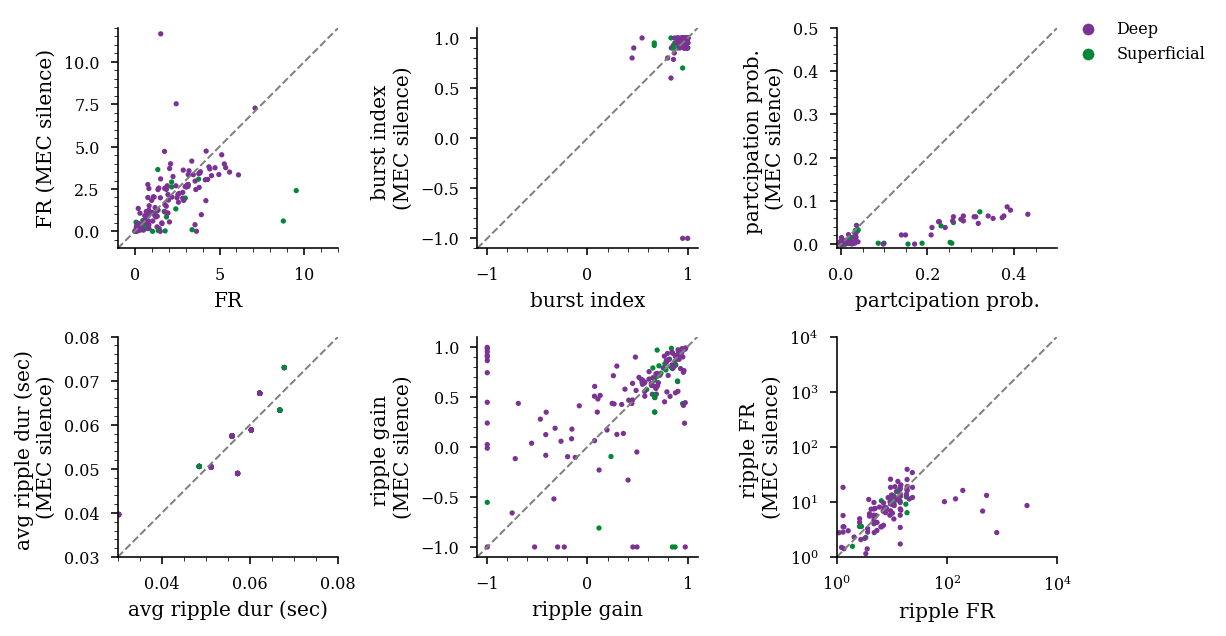

In [175]:
def plot_the_scatter(df,x,y,group_colors,ax,xlabel="",ylabel="",hue="deepSuperficial",scatter_size=7,legend=False):
    sns.scatterplot(
                data=df,
                x=x,
                y=y,
                hue=hue,
                linewidth=0,
                ax=ax,
                legend=legend,
                s=scatter_size,
                hue_order=group_colors.keys()
                )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
 
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='grey',ls='--',linewidth=1)

group_colors = {"Deep": '#7b3294',
                'Superficial': '#008837'} 

# group_colors_rem_shift = {"rem_shift_deep": '#7b3294',
#                 'non_rem_shift_sup': '#008837',
#                 'unknown':'grey'} 

sns.set_palette(sns.color_palette(group_colors.values()))

fig, axs = plt.subplots(2,3, figsize=functions.set_size('thesis', fraction=2, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.4, wspace=-.4)
axs = axs.ravel()

plot_the_scatter(df,"avg_fr_not_mec_silence","avg_fr_mec_silence",group_colors,axs[0],xlabel='FR',ylabel='FR (MEC silence)')
plot_the_scatter(df,"burst_idx_not_mec_silence","burst_idx_mec_silence",group_colors,axs[1],xlabel='burst index',ylabel='burst index \n(MEC silence)')
plot_the_scatter(df,"particip_not_mec_silence","particip_mec_silence",group_colors,axs[2],xlabel='partcipation prob.',ylabel='partcipation prob. \n(MEC silence)',legend=True)
plot_the_scatter(df,"ripple_dur_not_mec_silence","ripple_dur_mec_silence",group_colors,axs[3],xlabel='avg ripple dur (sec)',ylabel='avg ripple dur (sec) \n(MEC silence)')
plot_the_scatter(df,"ripple_gain_not_mec_silence","ripple_gain_mec_silence",group_colors,axs[4],xlabel='ripple gain',ylabel='ripple gain \n(MEC silence)')
plot_the_scatter(df,"avg_fr_in_rip_not_mec_silence","avg_fr_in_rip_mec_silence",group_colors,axs[5],xlabel='ripple FR',ylabel='ripple FR \n(MEC silence)')

axs[0].set_xlim(-1,12)
axs[0].set_ylim(-1,12)
axs[1].set_xlim(-1.1,1.1)
axs[1].set_ylim(-1.1,1.1)
axs[2].set_xlim(-.01,0.5)
axs[2].set_ylim(-.01,0.5)
axs[3].set_xlim(0.03,0.08)
axs[3].set_ylim(0.03,0.08)
axs[4].set_xlim(-1.1,1.1)
axs[4].set_ylim(-1.1,1.1)
# axs[5].set_xlim(-2,1000)
# axs[5].set_ylim(-2,1000)

axs[5].set_xscale("log")
axs[5].set_yscale("log")
axs[5].set_xlim(10e-1,10e3)
axs[5].set_ylim(10e-1,10e3)

for i in range(6):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i].set_aspect('equal')

axs[2].legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 1.1),frameon=False)

plt.savefig(os.path.join(fig_save_path,'opto_mec_firing_features_cheeseboard.pdf'),dpi=300,bbox_inches='tight')


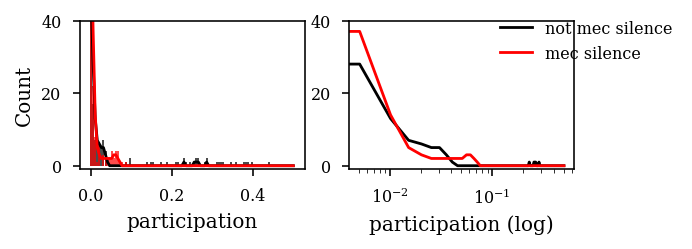

In [248]:
from scipy.ndimage import gaussian_filter1d

fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.75, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0.4, wspace=.2)
axs = axs.ravel()

width = 0.005
smooth_sd = 1
hist,bin_edges=np.histogram(df.particip_not_mec_silence,bins=np.arange(0,.5,width))
bin_centers = np.linspace(0, .5, len(hist))
smooth_hist = gaussian_filter1d(hist, smooth_sd)
axs[0].bar(bin_centers,hist,width=width,alpha=.7,color="k",label='not mec silence')
axs[0].plot(bin_centers,smooth_hist,color="k")

hist,bin_edges = np.histogram(df.particip_mec_silence,bins=np.arange(0,.5,width))
bin_centers = np.linspace(0, .5, len(hist))
smooth_hist = gaussian_filter1d(hist, smooth_sd)
axs[0].bar(bin_centers,hist,width=width,alpha=.7,color="r",label='mec silence')
axs[0].plot(bin_centers,smooth_hist,color="r")
axs[0].set_ylim(-1,40)
axs[0].set_xlabel('participation')
axs[0].set_ylabel('Count')


hist,bin_edges=np.histogram(df.particip_not_mec_silence,bins=np.arange(0,.5,width))
bin_centers = np.linspace(0, .5, len(hist))
smooth_hist = gaussian_filter1d(hist, smooth_sd)
axs[1].plot(bin_centers,smooth_hist,color="k",label='not mec silence')

hist,bin_edges = np.histogram(df.particip_mec_silence,bins=np.arange(0,.5,width))
bin_centers = np.linspace(0, .5, len(hist))
smooth_hist = gaussian_filter1d(hist, smooth_sd)
axs[1].plot(bin_centers,smooth_hist,color="r",label='mec silence')

axs[1].set_xlabel('participation (log)')
axs[1].set_ylabel('')
axs[1].set_ylim(-1,40)

axs[1].set_xscale("log")
# axs[1].legend()
axs[1].legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 1.1),frameon=False)
# axs[1].legend(loc='best',frameon=False)


plt.savefig(os.path.join(fig_save_path,'opto_mec_participation_hist_cheeseboard.pdf'),dpi=300,bbox_inches='tight')


In [176]:
swr_unit_metric = pd.DataFrame()
for basepath in basepaths:

    temp_swr_unit_metric = loading.load_SWRunitMetrics(basepath)
    temp_cell_metrics,_ = loading.load_cell_metrics(basepath)

    for _ in range(temp_swr_unit_metric.epoch.nunique()-1):
        temp_cell_metrics = temp_cell_metrics.append(temp_cell_metrics,ignore_index=True)
    
    temp_swr_unit_metric['deepSuperficial'] = temp_cell_metrics.deepSuperficial
    temp_swr_unit_metric['brainRegion'] = temp_cell_metrics.brainRegion
    temp_swr_unit_metric['putativeCellType'] = temp_cell_metrics.putativeCellType

    swr_unit_metric = swr_unit_metric.append(temp_swr_unit_metric,ignore_index=True)
    
swr_unit_metric

,particip,FRall,FRparticip,nSpkAll,nSpkParticip,epoch,deepSuperficial,brainRegion,putativeCellType
0,0.343105,2.774314,7.837143,0.465798,1.357595,pre,Deep,CA1,Pyramidal Cell
1,0.024973,0.174607,6.549549,0.029316,1.173913,pre,Deep,CA1,Pyramidal Cell
2,0.203040,2.024150,10.352096,0.339848,1.673797,pre,Superficial,CA3DG,Wide Interneuron
3,0.407166,5.703835,13.720334,0.957655,2.352000,pre,Deep,CA1,Pyramidal Cell
4,0.118350,0.730763,6.284692,0.122693,1.036697,pre,Superficial,CA3DG,Pyramidal Cell
...,...,...,...,...,...,...,...,...,...
512,0.409800,5.231585,12.514301,0.718263,1.752717,post,Deep,CA1,Pyramidal Cell
513,0.747773,11.428377,15.066504,1.569042,2.098287,post,Deep,CA1,Pyramidal Cell
514,0.844098,20.524846,24.017990,2.817929,3.338391,post,Deep,CA1,Pyramidal Cell
515,0.538976,9.631794,17.934025,1.322383,2.453512,post,Deep,CA1,Wide Interneuron


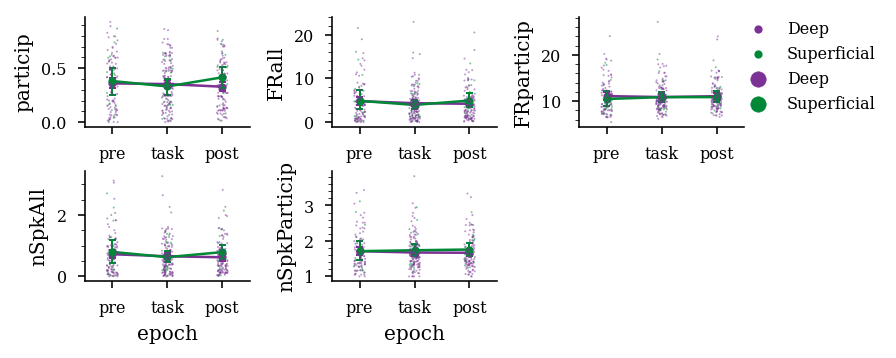

In [178]:
def plot_paired_plot(df,y,group_colors,ax,x="epoch",hue="deepSuperficial"):
    sns.pointplot(
            data=df,
            x=x, 
            y=y, 
            hue=hue,
            ci=95,
            capsize=.1, 
            hue_order=group_colors.keys(), 
            kind="point",
            ax=ax,
            scale=.5,
            errwidth=1
            ) 
    sns.stripplot(x=x, y=y,hue=hue,hue_order=group_colors.keys(),
        data=df,size=1,linewidth=0,ax=ax,alpha=.5)

fig, axs = plt.subplots(2,3, figsize=functions.set_size('thesis', fraction=1, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.4, wspace=.5)
axs = axs.ravel()

group_colors = {"Deep": '#7b3294',
            'Superficial': '#008837'} 
sns.set_palette(sns.color_palette(group_colors.values()))

idx = (swr_unit_metric.putativeCellType=="Pyramidal Cell") & (swr_unit_metric.brainRegion=="CA1")

plot_paired_plot(swr_unit_metric[idx],"particip",group_colors,axs[0])
plot_paired_plot(swr_unit_metric[idx],"FRall",group_colors,axs[1])
plot_paired_plot(swr_unit_metric[idx],"FRparticip",group_colors,axs[2])
plot_paired_plot(swr_unit_metric[idx],"nSpkAll",group_colors,axs[3])
plot_paired_plot(swr_unit_metric[idx],"nSpkParticip",group_colors,axs[4])

axs[0].legend("",frameon=False)
axs[1].legend("",frameon=False)
axs[3].legend("",frameon=False)
axs[4].legend("",frameon=False)

axs[2].legend(loc='best', bbox_to_anchor=(.9, 0., 0.5, 1.1),frameon=False)
    
for i in range(6):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs[5].axes.get_xaxis().set_ticks([])
axs[5].axes.get_yaxis().set_ticks([])

right_side = axs[5].spines["left"]
right_side.set_visible(False)
top_side = axs[5].spines["bottom"]
top_side.set_visible(False)

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")

plt.savefig(os.path.join(fig_save_path,'opto_mec_pre_task_post_cheeseboard.pdf'),dpi=300,bbox_inches='tight')

In [ ]:
# basepath = r'A:\OptoMECLEC\OML18\day1'

# # channel info
# nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
# # ripple epochs
# ripples = loading.load_ripples_events(basepath)
# # spike data and a lot more
# cell_metrics,cell_metrics_data = loading.load_cell_metrics(basepath)
# # rem shifting
# df,data_dict = loading.load_theta_rem_shift(basepath)

# example figure below

In [165]:
basepath = r'A:\OptoMECLEC\OML18\day1'

# channel info
nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
# ripple epochs
ripples = loading.load_ripples_events(basepath)
# spike data and a lot more
cell_metrics,cell_metrics_data = loading.load_cell_metrics(basepath)
# rem shifting
df,data_dict = loading.load_theta_rem_shift(basepath)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [166]:
# load stimulation
stim_on = load_stimint(basepath)
mec_silence_epochs = nel.EpochArray(stim_on)
print(mec_silence_epochs)

# load position
outbound,inbound = load_postrials(basepath)
# pos = np.vstack([outbound,inbound])
# idx = np.argsort(pos[:,0])
# pos = pos[idx,:]

fs_pos = 1/statistics.mode(np.diff(outbound[:,0]))

pos_outbound = nel.AnalogSignalArray(data=[outbound[:,1]],timestamps=outbound[:,0], fs=fs_pos)
pos_inbound = nel.AnalogSignalArray(data=[inbound[:,1]],timestamps=inbound[:,0], fs=fs_pos)

print(pos_outbound)
print(pos_inbound)

# make spike train object
st = nel.SpikeTrainArray(timestamps=np.array(cell_metrics_data['spikes'],dtype="object"), fs=fs_dat)

<EpochArray at 0x1ae23cb0760: 41 epochs> of length 30:30:176 minutes
<AnalogSignalArray at 0x1ae23cb0160: 1 signals (43 segments)> for a total of 35:22:843 minutes
<AnalogSignalArray at 0x1ae22220100: 1 signals (43 segments)> for a total of 29:14:183 minutes


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


# here, we can see that mec silencing happens during the outbound interval on the linear track

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


Text(0.5, 1.0, 'mec_silence_epochs pos_outbound')

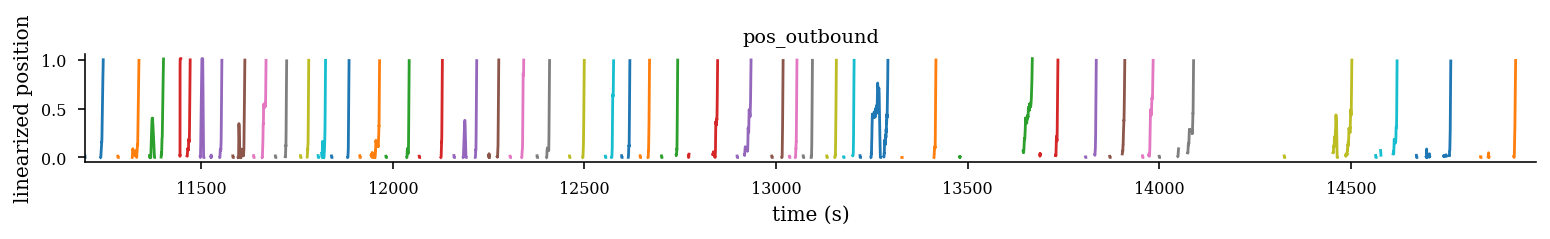

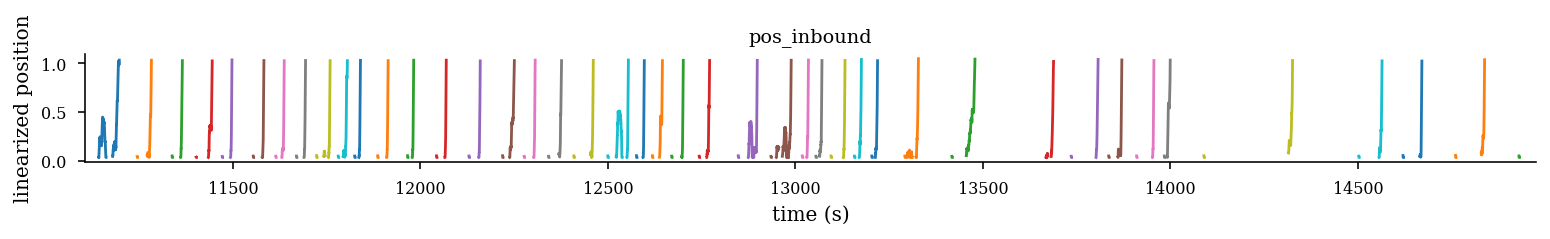

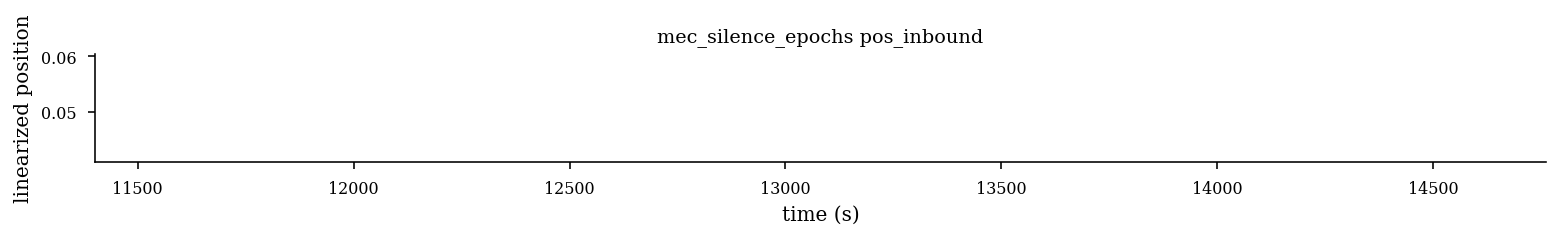

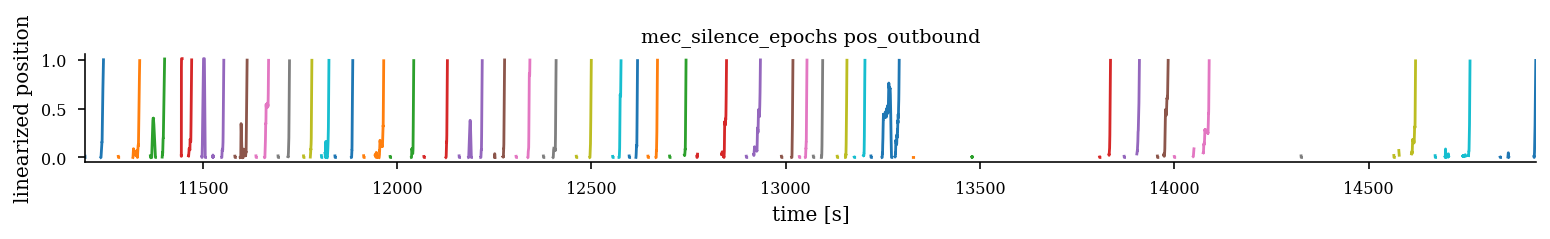

In [167]:
fig = plt.figure(figsize=(13,1))
npl.plot(pos_outbound)
ax = plt.gca()
ax.set_ylabel('linearized position')
npl.utils.clear_right(ax)
npl.utils.clear_top(ax)
ax.set_title('pos_outbound')

fig = plt.figure(figsize=(13,1))
npl.plot(pos_inbound)
ax = plt.gca()
ax.set_ylabel('linearized position')
npl.utils.clear_right(ax)
npl.utils.clear_top(ax)
ax.set_title('pos_inbound')


fig = plt.figure(figsize=(13,1))
npl.plot(pos_inbound[mec_silence_epochs])
ax = plt.gca()
ax.set_ylabel('linearized position')
npl.utils.clear_right(ax)
npl.utils.clear_top(ax)
ax.set_title('mec_silence_epochs pos_inbound')

ig = plt.figure(figsize=(13,1))
npl.plot(pos_outbound[mec_silence_epochs])
ax = plt.gca()
ax.set_xlabel('time [s]')
ax.set_ylabel('linearized position')
npl.utils.clear_right(ax)
npl.utils.clear_top(ax)
ax.set_title('mec_silence_epochs pos_outbound')


AttributeError: 'NoneType' object has no attribute 'plot'

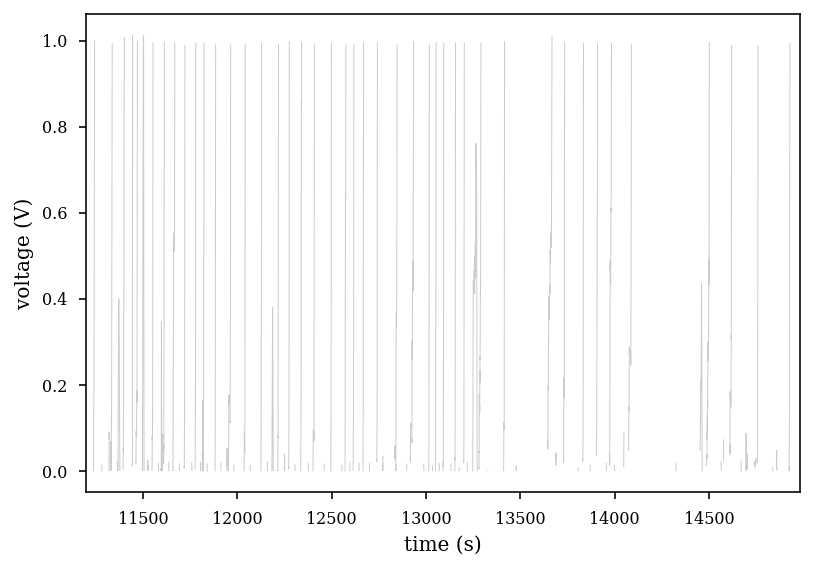

In [113]:
pos_outbound.data

ax = npl.plot(pos_outbound, lw=0.5, c='0.8')
unit_id = 9
_, pos_at_spikes = pos_outbound.asarray(at=st[:,unit_id].time)
ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.')
ax.set_aspect('equal')

In [168]:
df,data_dict = loading.load_theta_rem_shift(basepath)


In [169]:
unit_ids_to_keep = list(np.where((cell_metrics.brainRegion == "CA1") & (cell_metrics.putativeCellType == "Pyramidal Cell"))[0]+1)
st_ca1 = st._unit_subset(unit_ids_to_keep)

# unit_ids_to_keep = list(np.where((cell_metrics.brainRegion == "CA1") &
#     (cell_metrics.putativeCellType == "Pyramidal Cell") &
#     (df.rem_shift == 1))[0]+1)
# st_rem_shift = st._unit_subset(unit_ids_to_keep)

# unit_ids_to_keep = list(np.where((cell_metrics.brainRegion == "CA1") &
#     (cell_metrics.putativeCellType == "Pyramidal Cell") &
#     (df.non_rem_shift == 1))[0]+1)
# st_non_rem_shift = st._unit_subset(unit_ids_to_keep)

# unit_ids_to_keep = list(np.where(cell_metrics.putativeCellType == "Pyramidal Cell")[0]+1)
# st_pyr = st._unit_subset(unit_ids_to_keep)

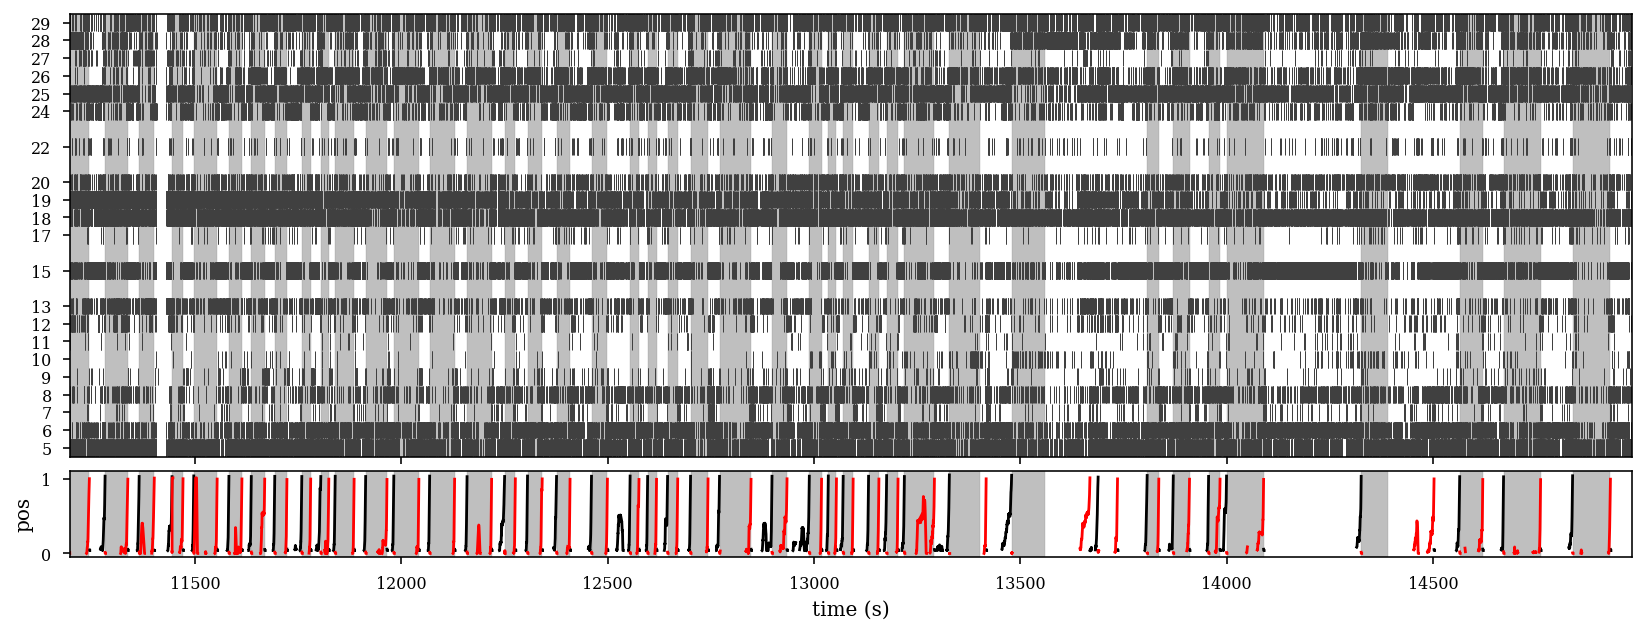

In [172]:
with npl.FigureManager(show=True, figsize=(14,5)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)

    npl.rasterplot(st_ca1, lw=0.5, ax=ax)
    # npl.rasterplot(st_non_rem_shift, lw=0.5, ax=ax,color=npl.colors.sweet.green)
    
    npl.epochplot(mec_silence_epochs)

    divider = make_axes_locatable(ax)

    ax_pos = divider.append_axes("bottom", size=0.6, pad=0.1)
    npl.plot(pos_inbound, ax=ax_pos,color='k')
    npl.plot(pos_outbound, ax=ax_pos,color='r')
    npl.epochplot(mec_silence_epochs, ax=ax_pos)


    xlims = (pos_outbound.time.min(), pos_outbound.time.max())

    ax.set_xlim(xlims)
    ax_pos.set_xlim(xlims)
    ax_pos.set_ylabel('pos')

    plt.savefig(os.path.join(fig_save_path,'opto_silence_raster.pdf'),dpi=300,bbox_inches='tight')

14982.234466666667